In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import isfile, join
from os import listdir

from quick_a_b import *
from aux_reg_trees import *

# Imports for regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

/home/asoria/Documents/proyecto_bretagne/port_st_guenole
/home/asoria/Documents/proyecto_bretagne/port_st_guenole/report_original.xml
/home/asoria/Documents/proyecto_bretagne/port_st_guenole/report_blurred.xml
Initial folder checks
N images  80
Folder exists: True , and there are 80 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  43
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


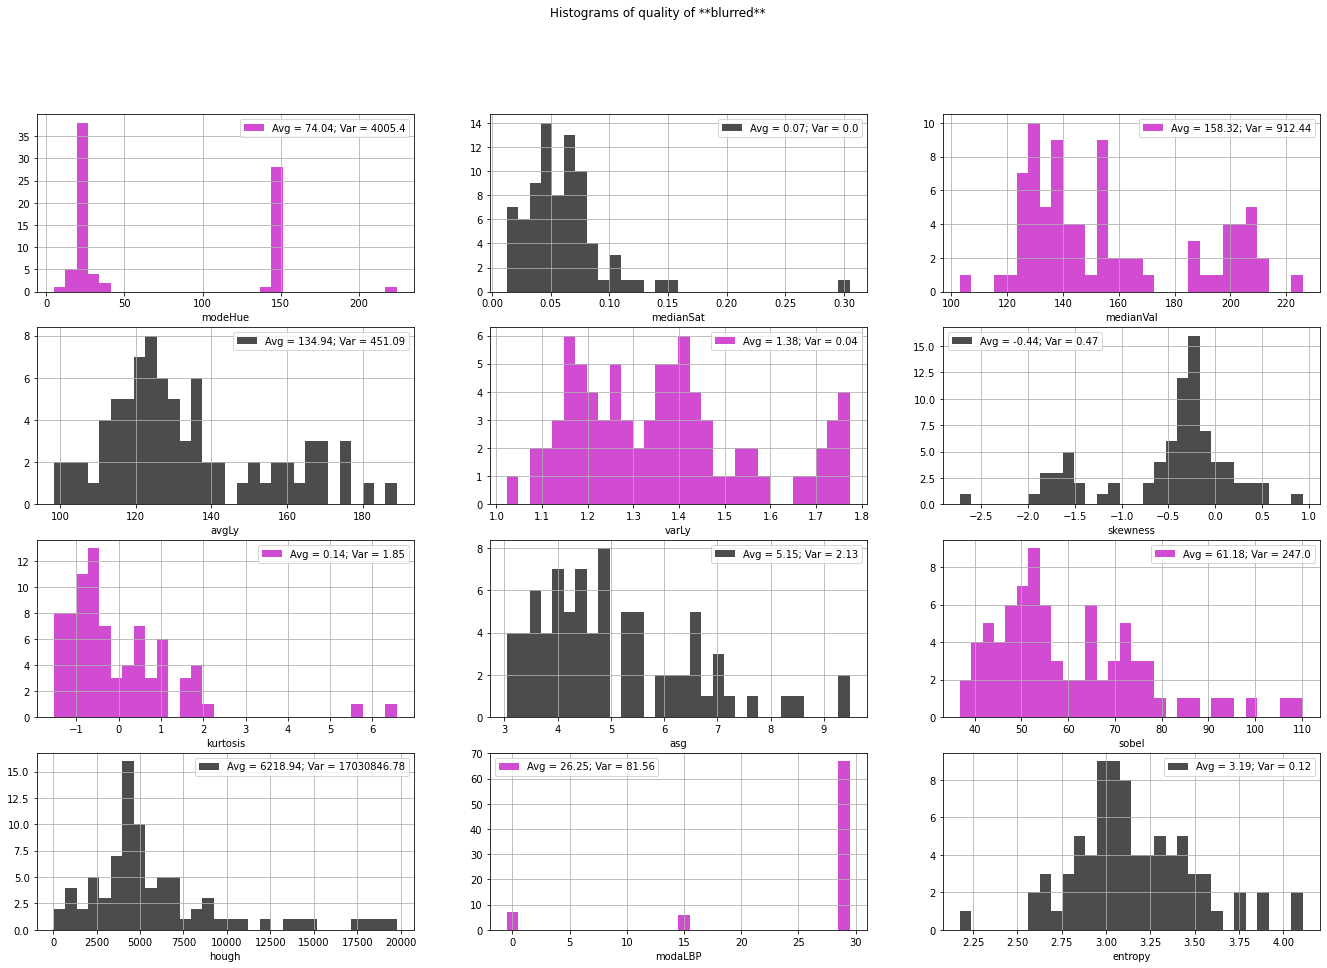

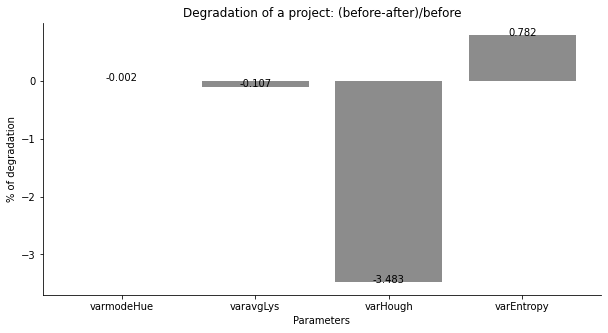

DONE report before path
DONE results after path
                before    after  degradation_perc
n_calibrated       799      720          9.887359
optim             0.54     13.7        -24.370370
2D_BBA         2070272  6058849       -192.659564
3D_BBA          760961  2195664       -188.538309
keypoints_img    22292    22204          0.394760
matches_img       2169     7619       -251.267865
mre             0.2055   0.3386        -64.768856
dMTP1-2            1.3      1.3          0.000000
dMTP1-3            1.3      1.3          0.000000
<BarContainer object of 9 artists>


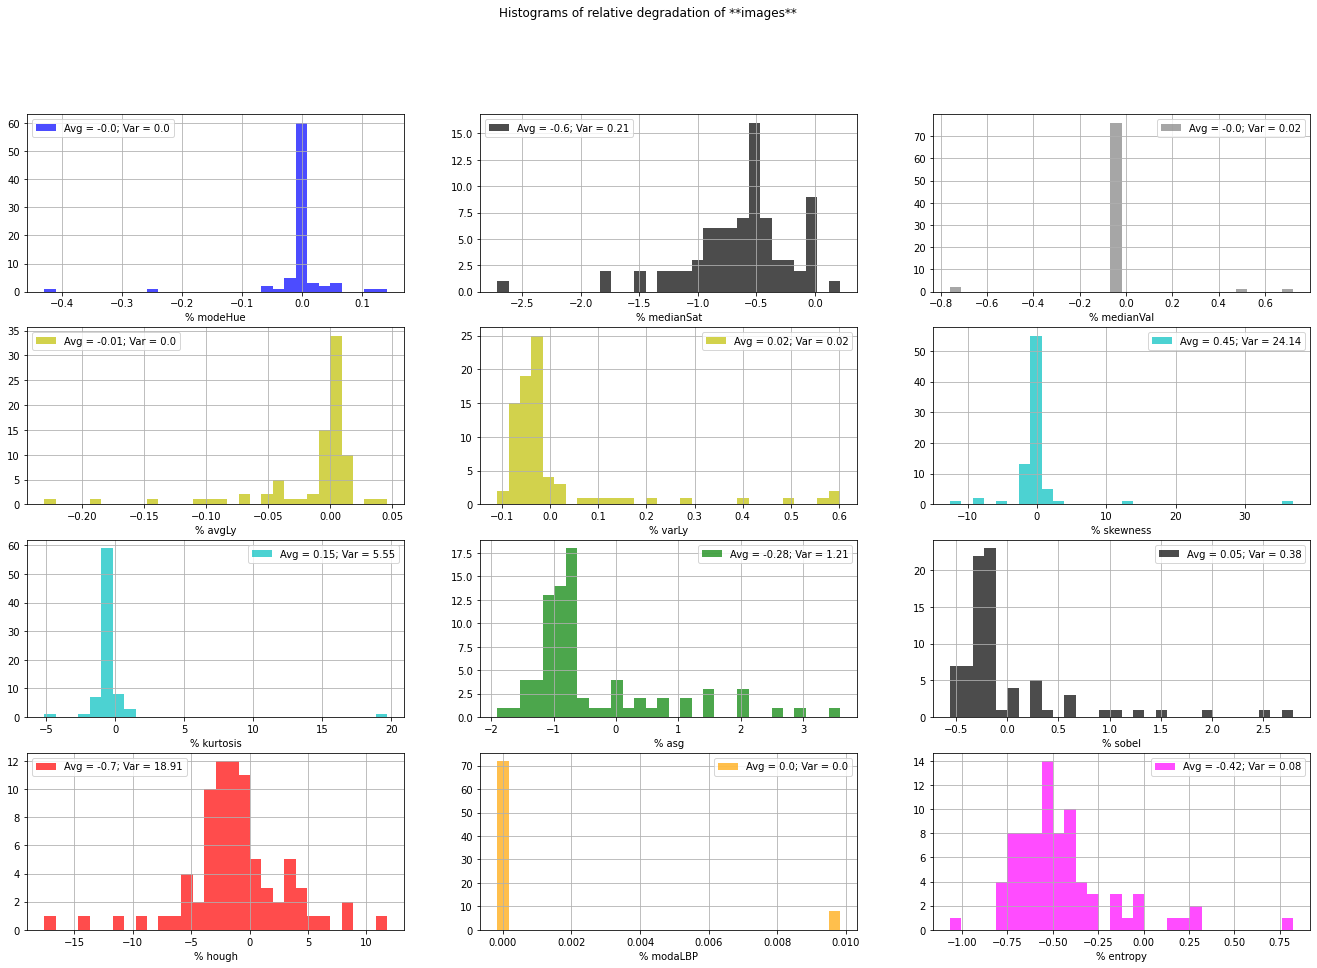

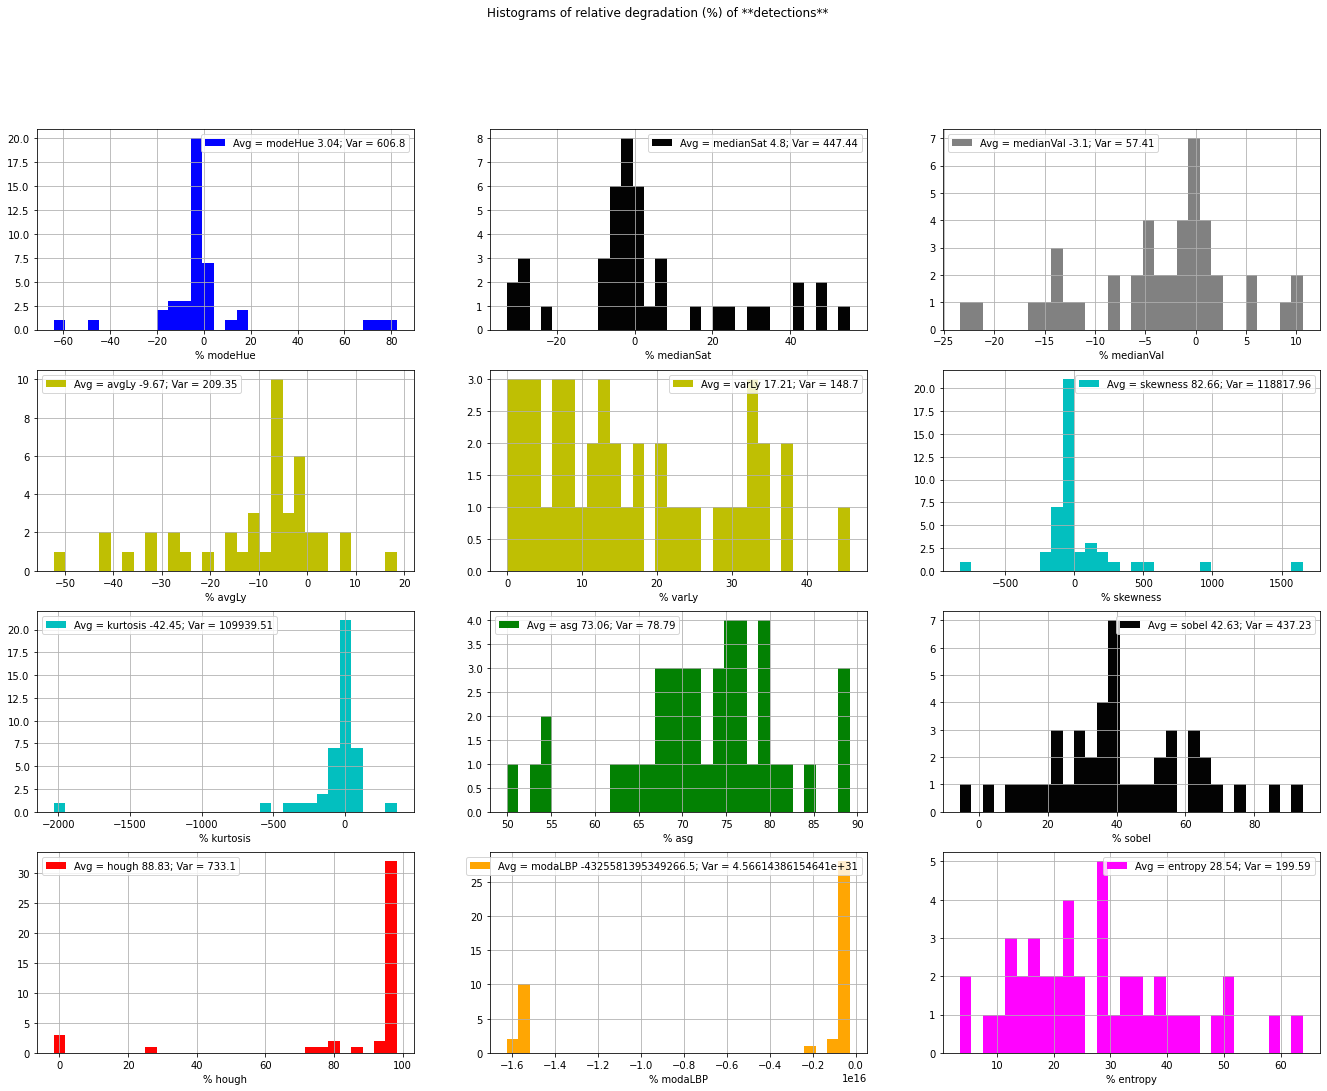

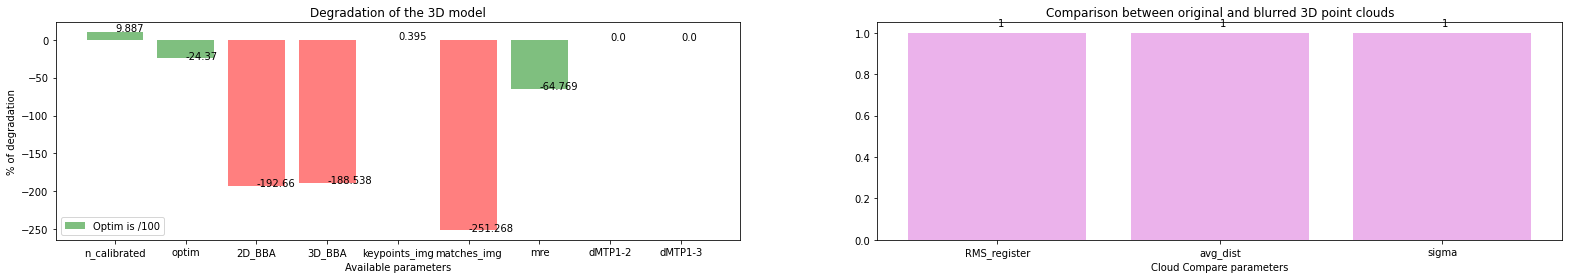

/home/asoria/Documents/proyecto_bretagne/parking_st_guenole
/home/asoria/Documents/proyecto_bretagne/parking_st_guenole/report_original.xml
/home/asoria/Documents/proyecto_bretagne/parking_st_guenole/report_blurred.xml
Initial folder checks
N images  184
Folder exists: True , and there are 184 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  106
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


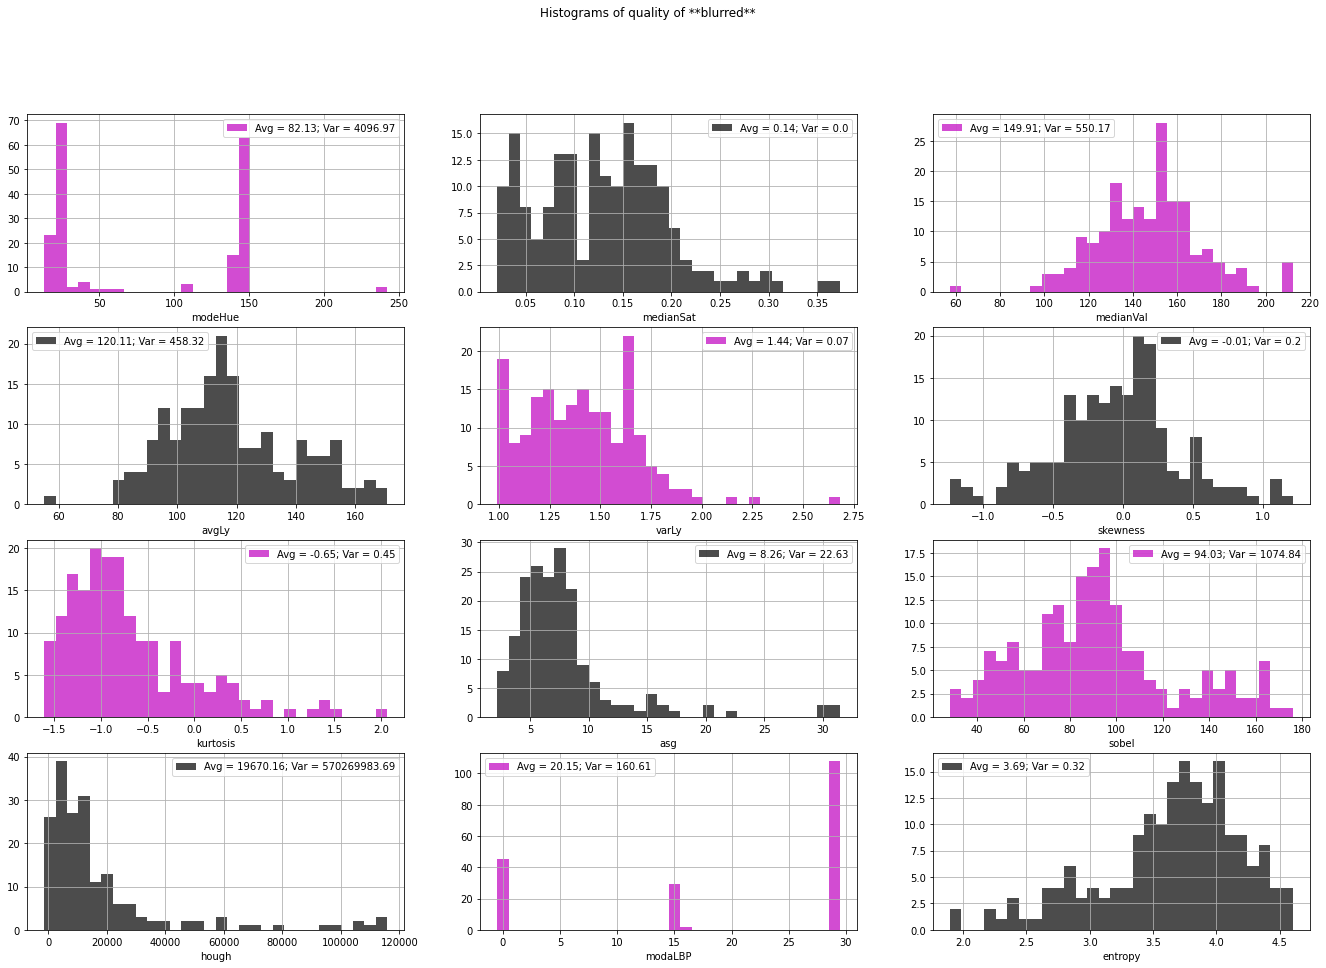

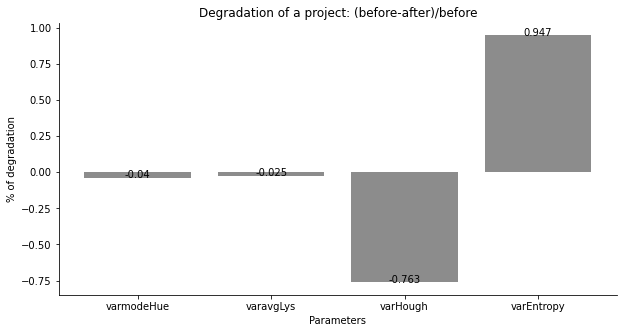

DONE report before path
DONE results after path
                before     after  degradation_perc
n_calibrated       546      1068        -95.604396
optim             0.13     14.41       -109.846154
2D_BBA         4849659  21233464       -337.834165
3D_BBA         1774903   6095150       -243.407499
keypoints_img    27965     32273        -15.404970
matches_img       5356     19017       -255.059746
mre             0.2161    0.3202        -48.172143
dMTP1-2            1.3       1.3          0.000000
dMTP1-3            1.3       1.3          0.000000
<BarContainer object of 9 artists>


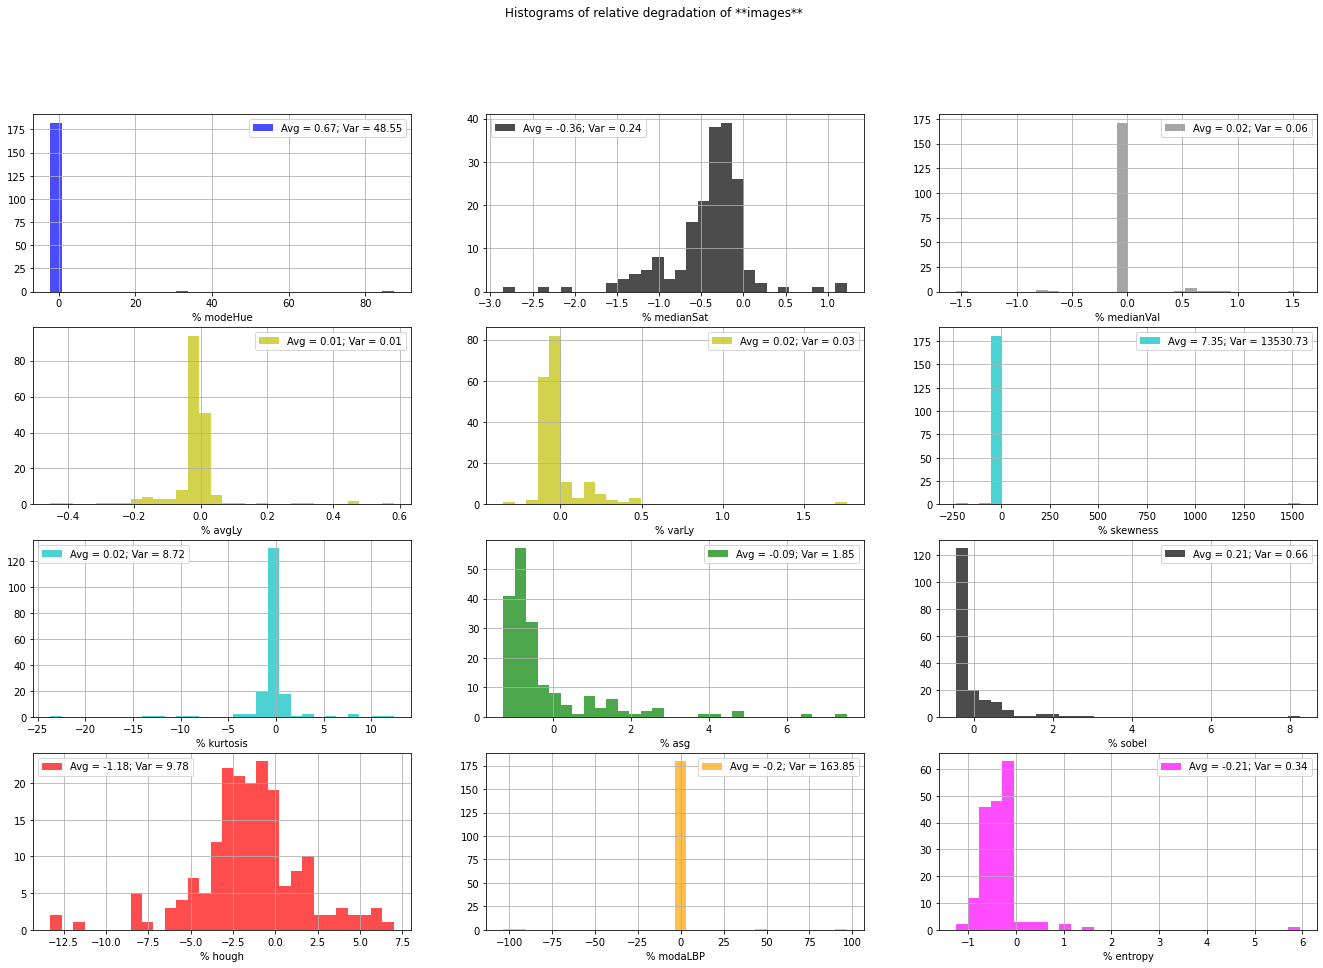

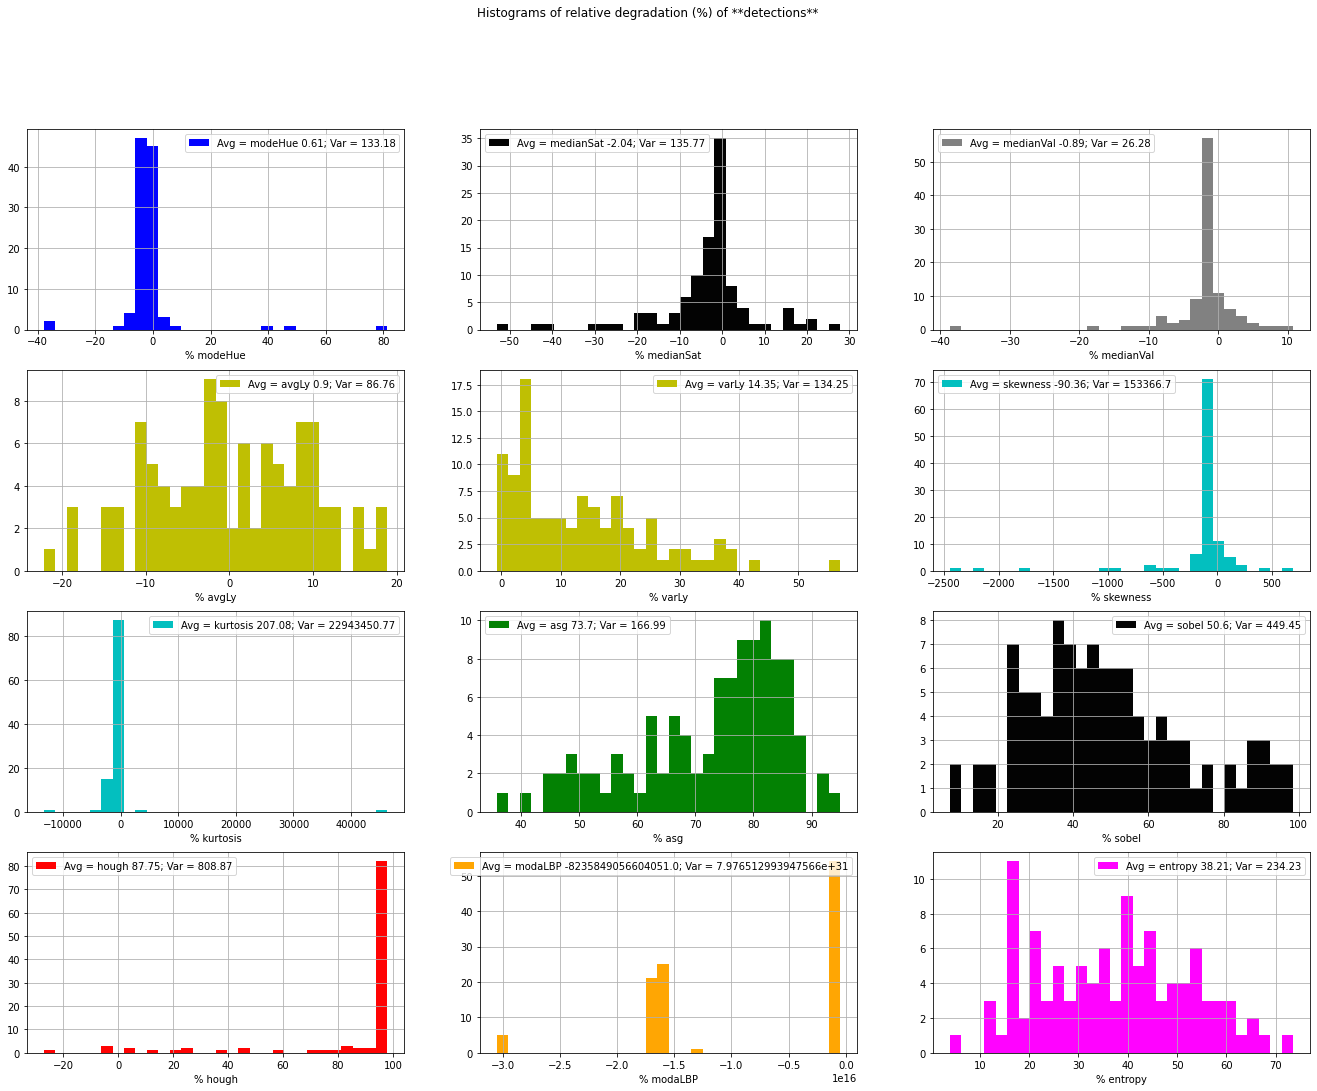

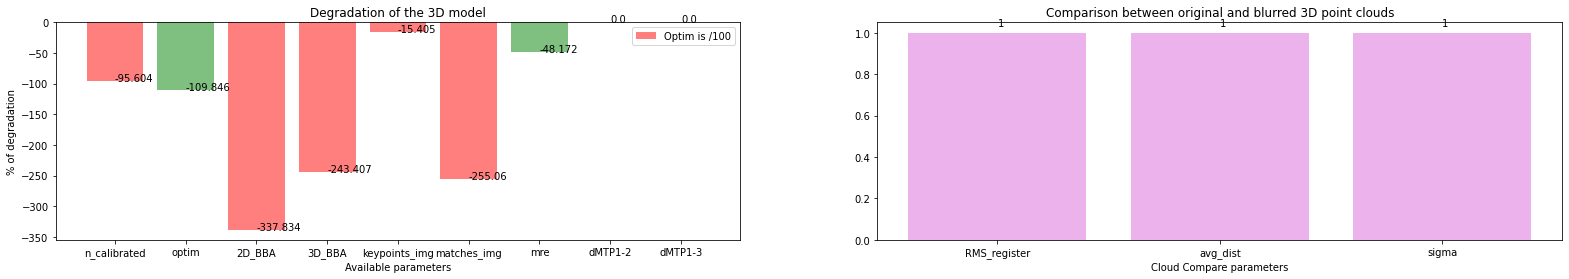

/home/asoria/Documents/proyecto_bretagne/port_kerity
/home/asoria/Documents/proyecto_bretagne/port_kerity/report_original.xml
/home/asoria/Documents/proyecto_bretagne/port_kerity/report_blurred.xml
Initial folder checks
N images  79
Folder exists: True , and there are 79 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  76
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


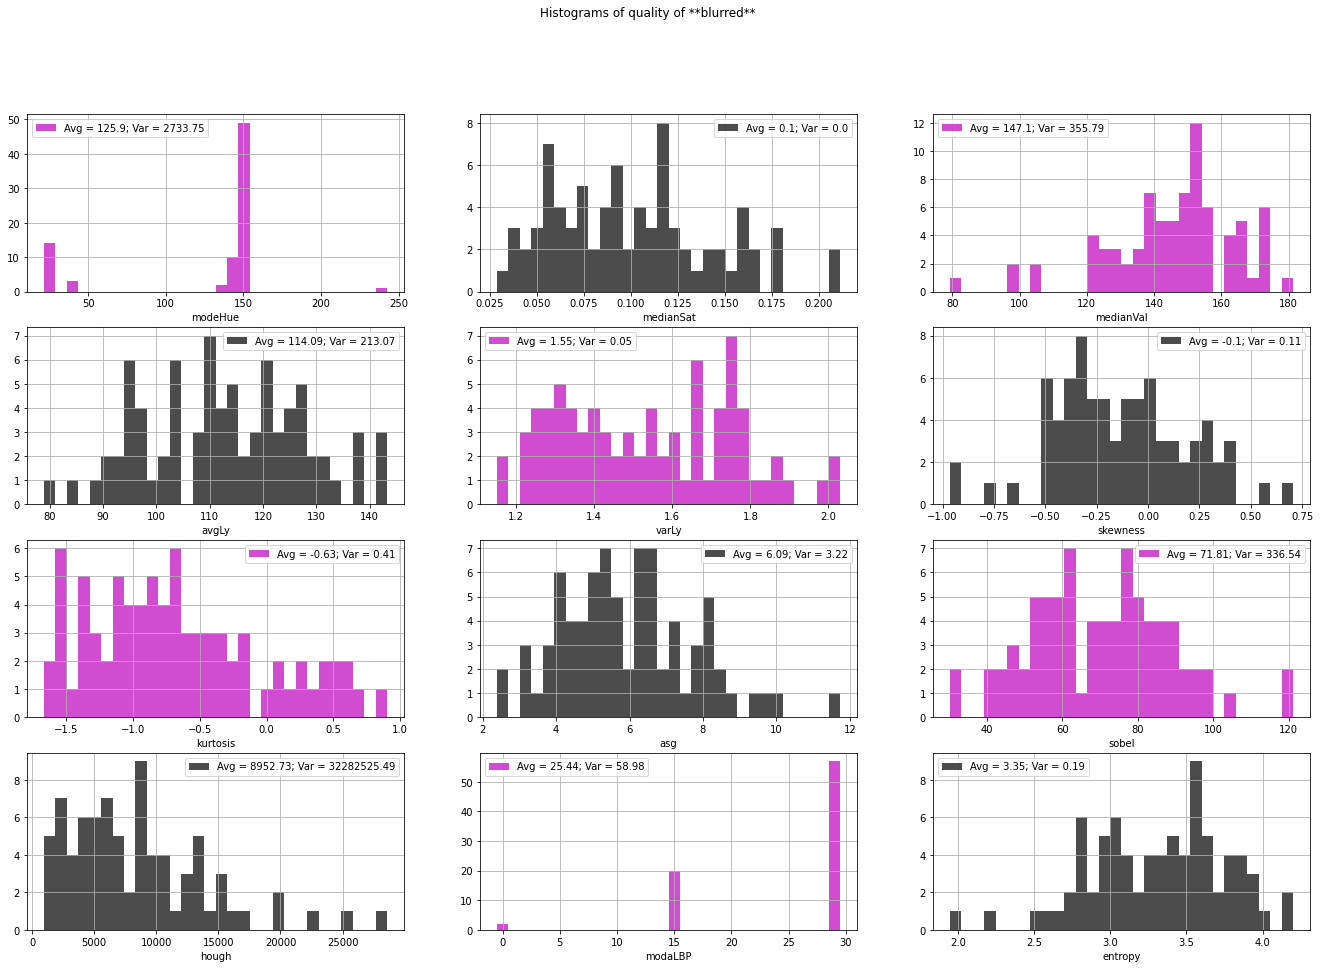

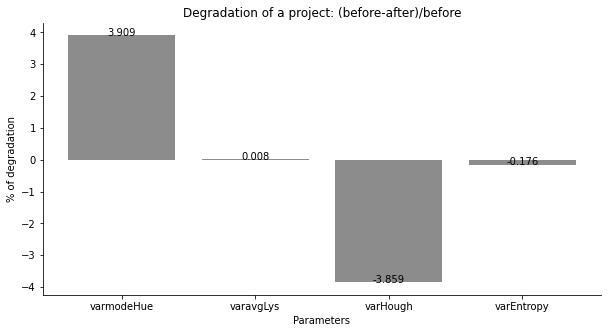

DONE report before path
DONE results after path
                before    after  degradation_perc
n_calibrated       738      780         -5.691057
optim             0.47    14.56        -29.978723
2D_BBA         3177298  8417417       -164.923750
3D_BBA         1161222  2979183       -156.555852
keypoints_img    24742    23755          3.989168
matches_img       4082    10839       -165.531602
mre             0.2178   0.3506        -60.973370
dMTP1-2            1.3      1.3          0.000000
dMTP1-3            1.3      1.3          0.000000
<BarContainer object of 9 artists>


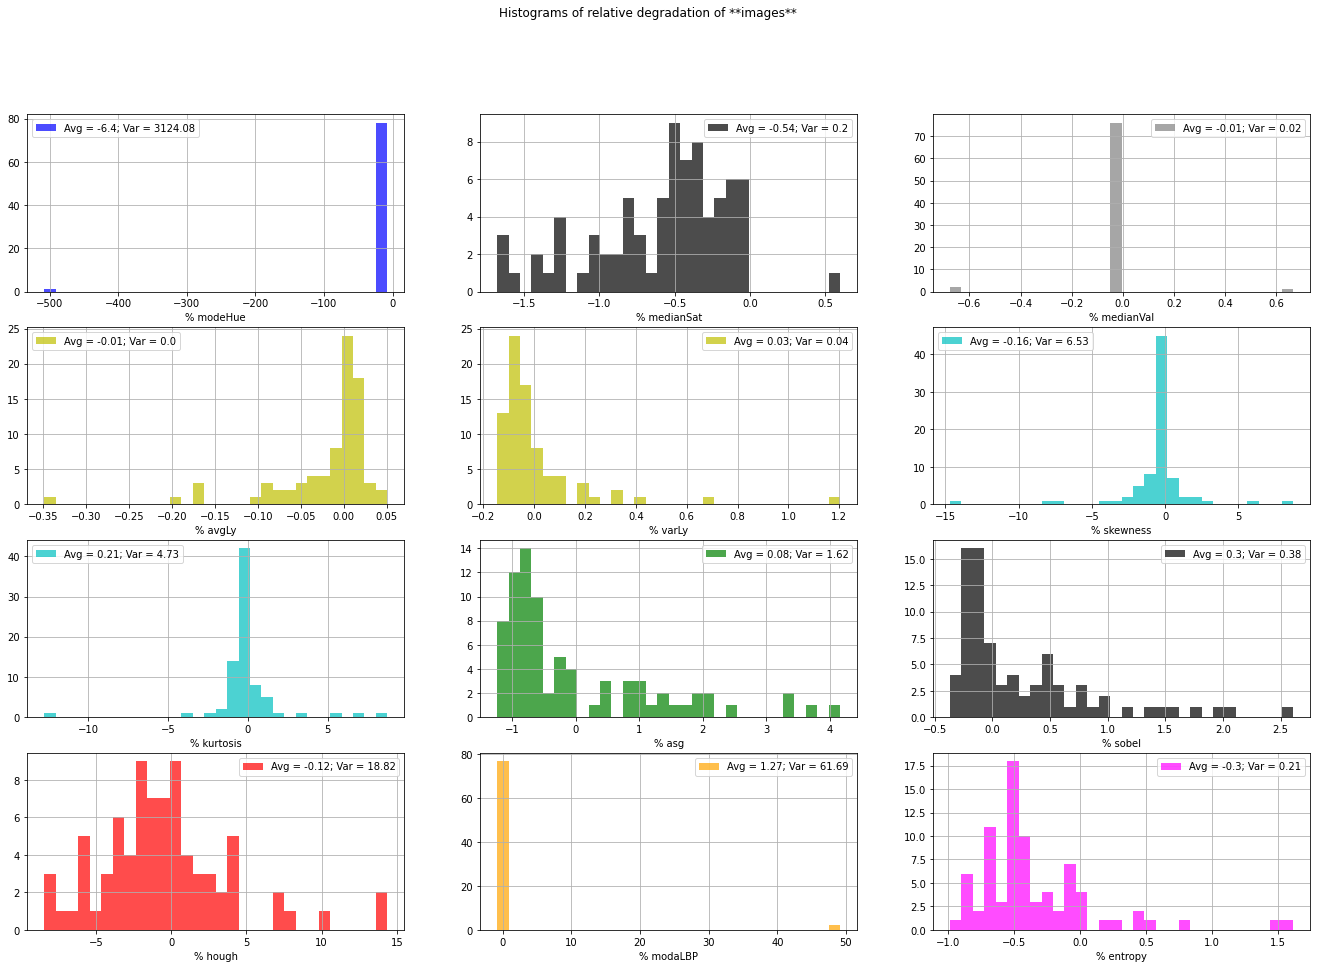

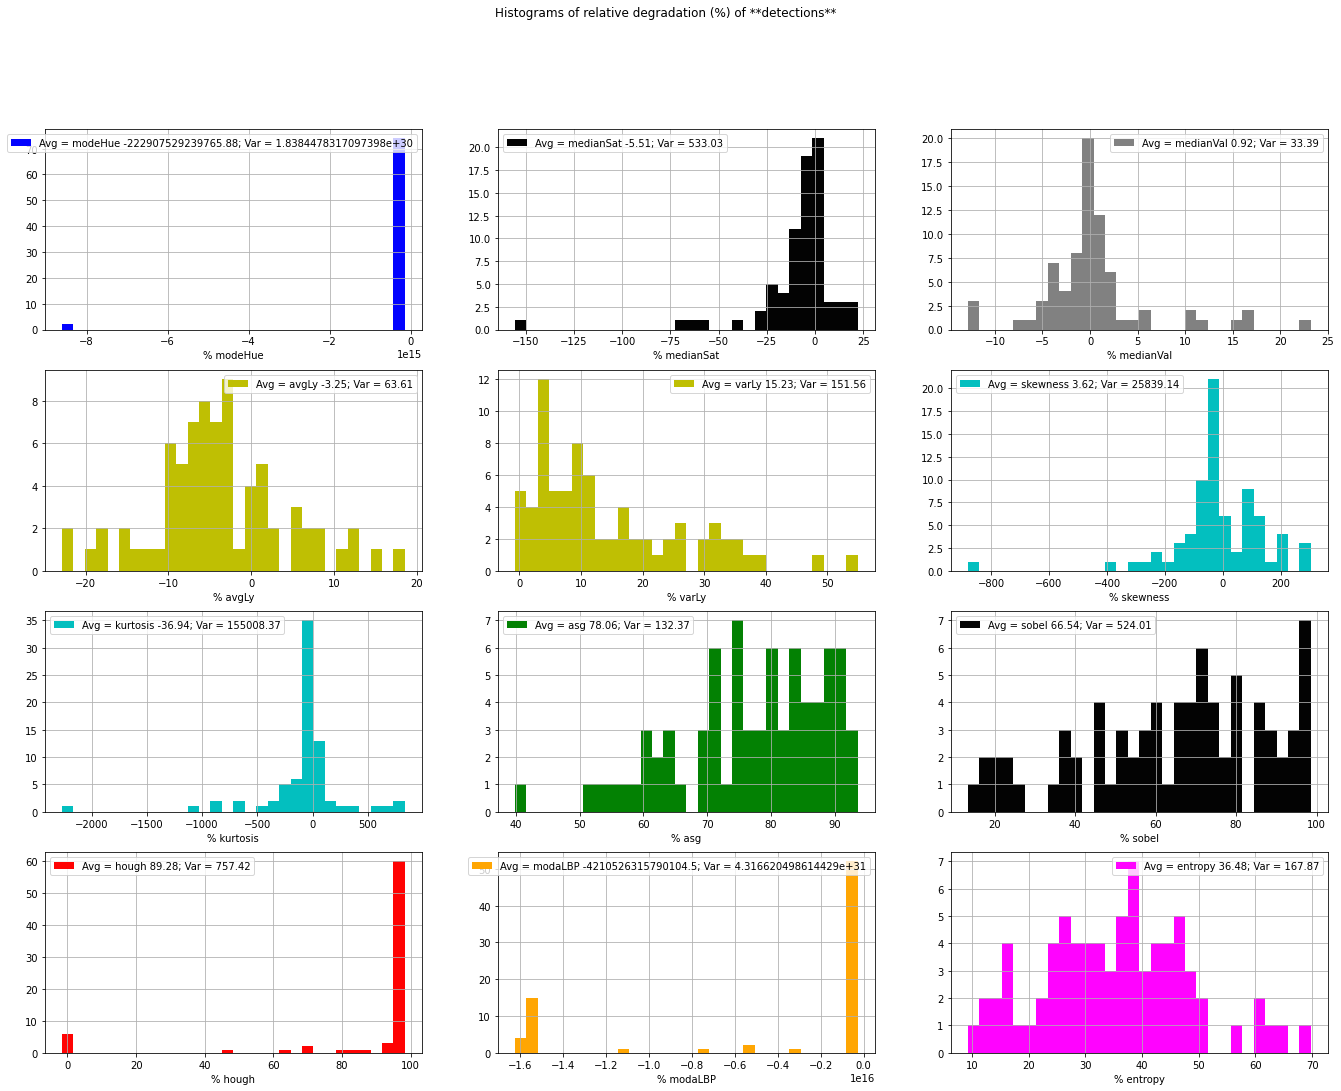

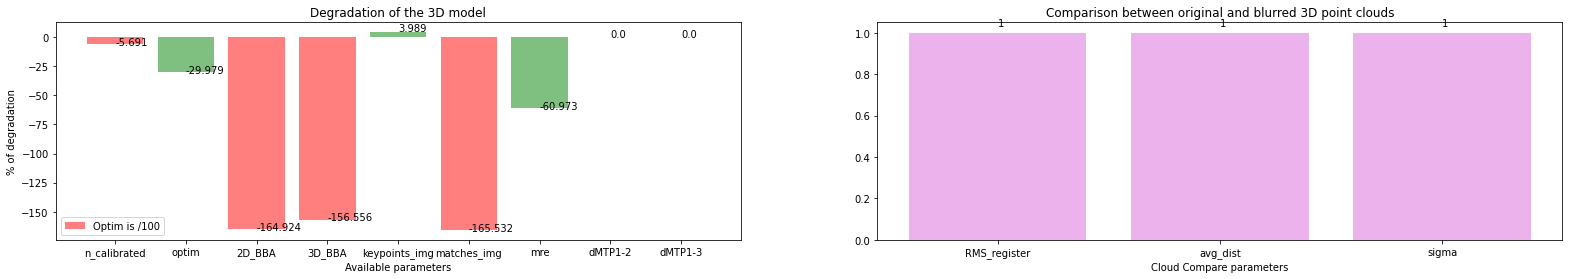

/home/asoria/Documents/proyecto_cars/black_plates_singapur
/home/asoria/Documents/proyecto_cars/black_plates_singapur/report_original.xml
/home/asoria/Documents/proyecto_cars/black_plates_singapur/report_blurred.xml
Initial folder checks
N images  50
Folder exists: True , and there are 50 images of resolution: 1920 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  16
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


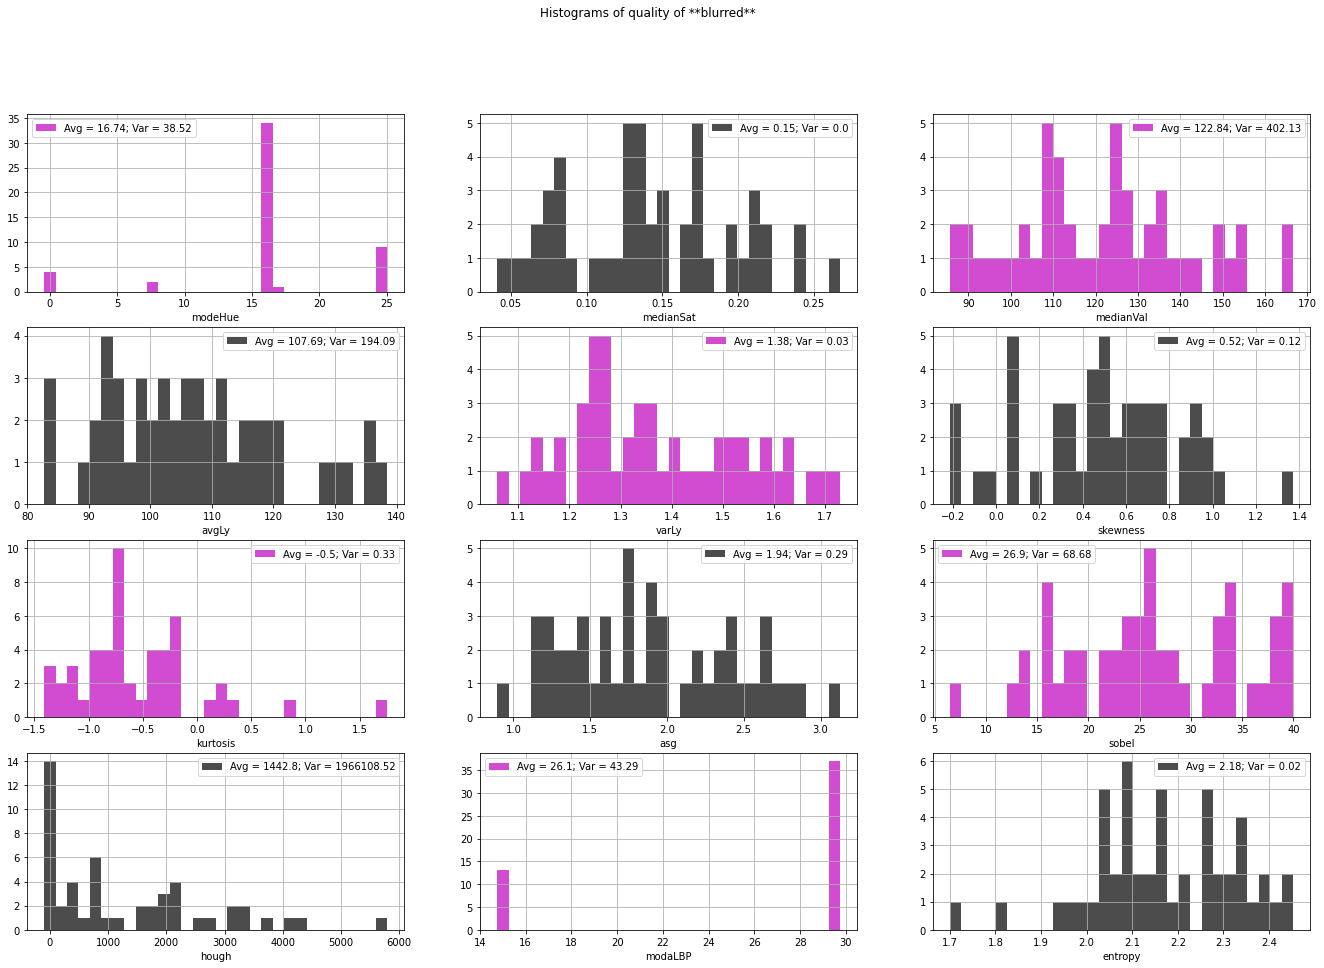

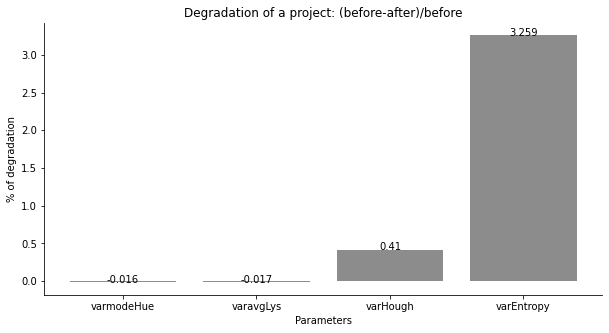

DONE report before path
DONE results after path
               before   after  degradation_perc
n_calibrated      213     230         -7.981221
optim            0.87     0.9         -0.034483
2D_BBA         524591  484508          7.640810
3D_BBA         214765  203356          5.312318
keypoints_img   13543   13612         -0.509488
matches_img      2276    1937         14.894552
mre             0.303  0.3183         -5.049505
dMTP1-2           1.3     1.3          0.000000
dMTP1-3           1.3     1.3          0.000000
<BarContainer object of 9 artists>


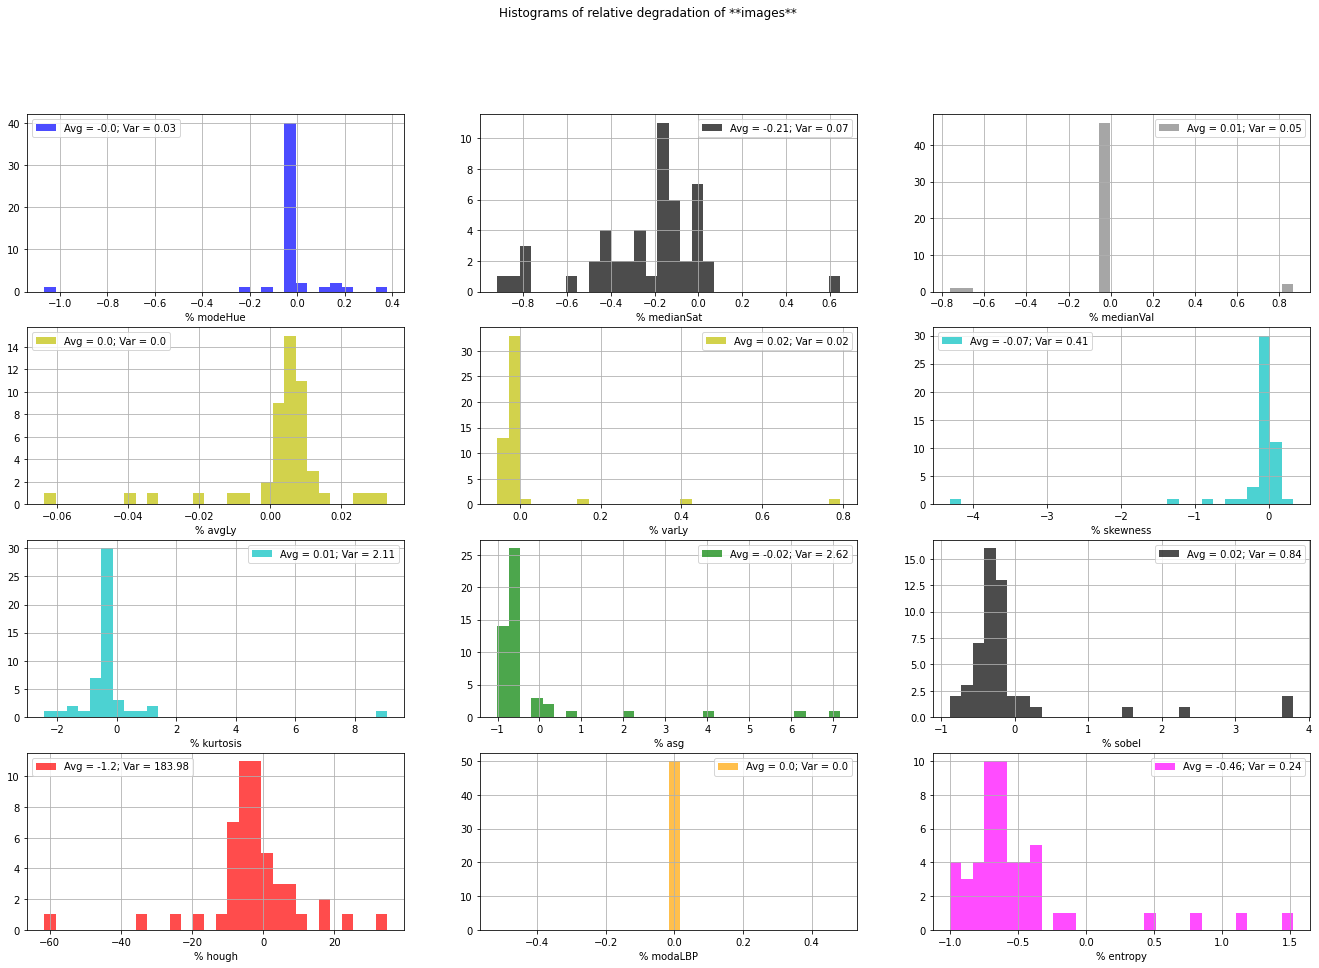

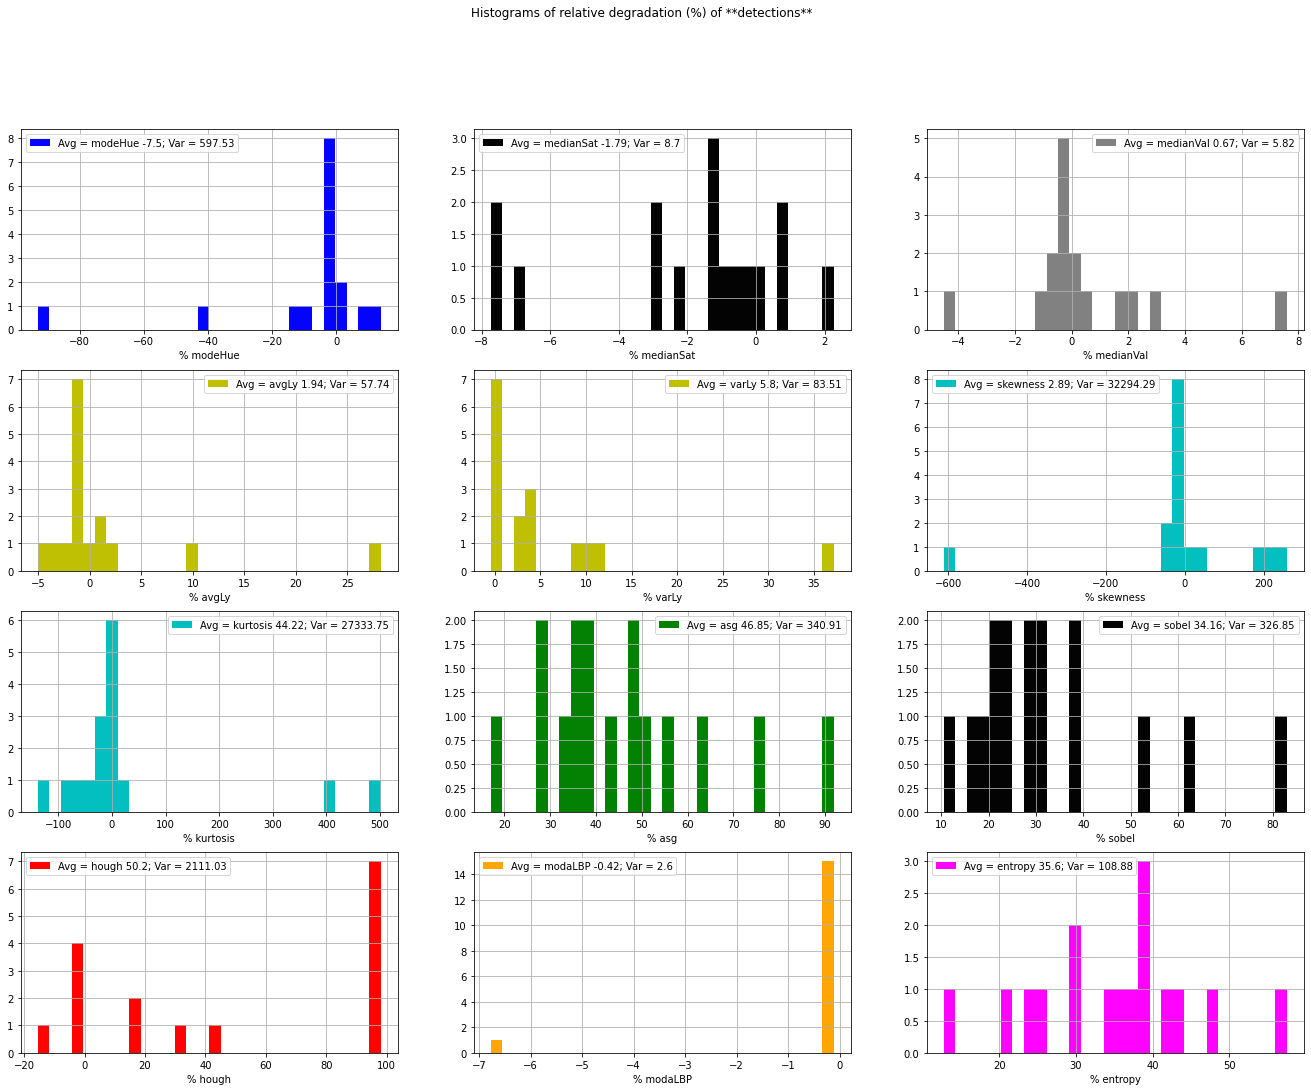

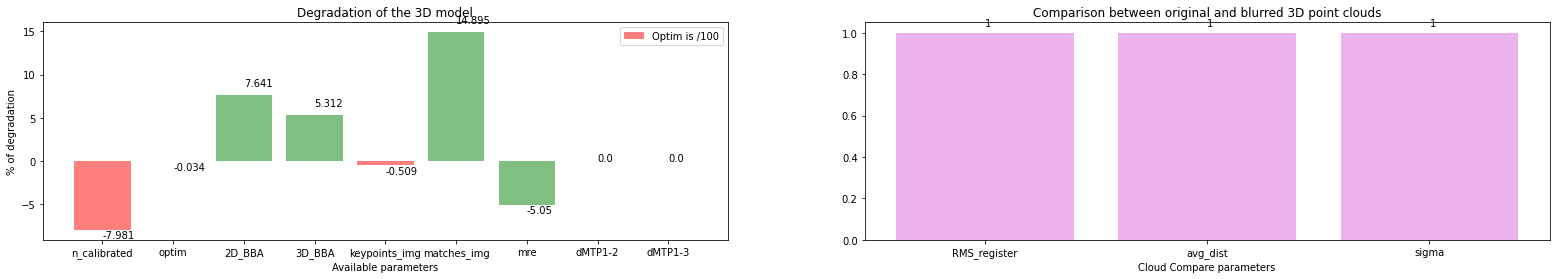

/home/asoria/Documents/proyecto_cars/parking_entrance
/home/asoria/Documents/proyecto_cars/parking_entrance/report_original.xml
/home/asoria/Documents/proyecto_cars/parking_entrance/report_blurred.xml
Initial folder checks
N images  49
Folder exists: True , and there are 49 images of resolution: 1080 px, 1440 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  2
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


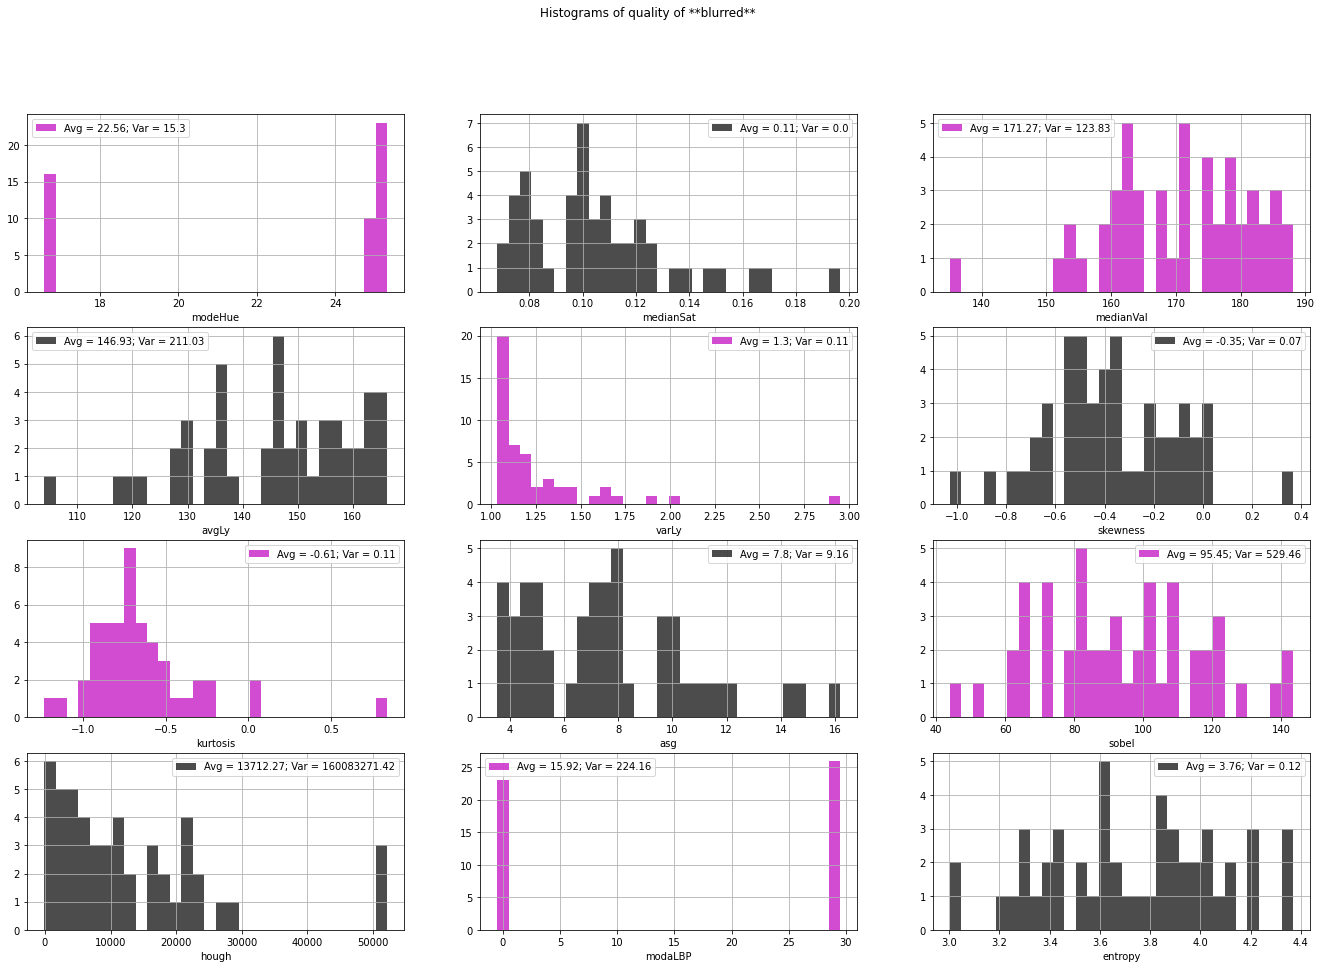

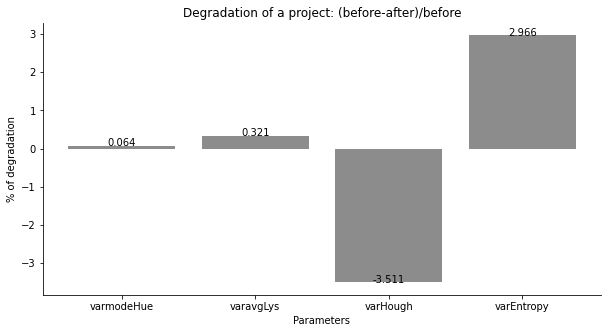

DONE report before path
DONE results after path
                before    after  degradation_perc
n_calibrated       443      432          2.483070
optim             0.11     0.03          0.727273
2D_BBA         4791668  4705971          1.788459
3D_BBA         1869486  1843612          1.384017
keypoints_img    25611    26125         -2.006950
matches_img       8550     8621         -0.830409
mre             0.2708   0.2684          0.886263
dMTP1-2            1.3      1.3          0.000000
dMTP1-3            1.3      1.3          0.000000
<BarContainer object of 9 artists>


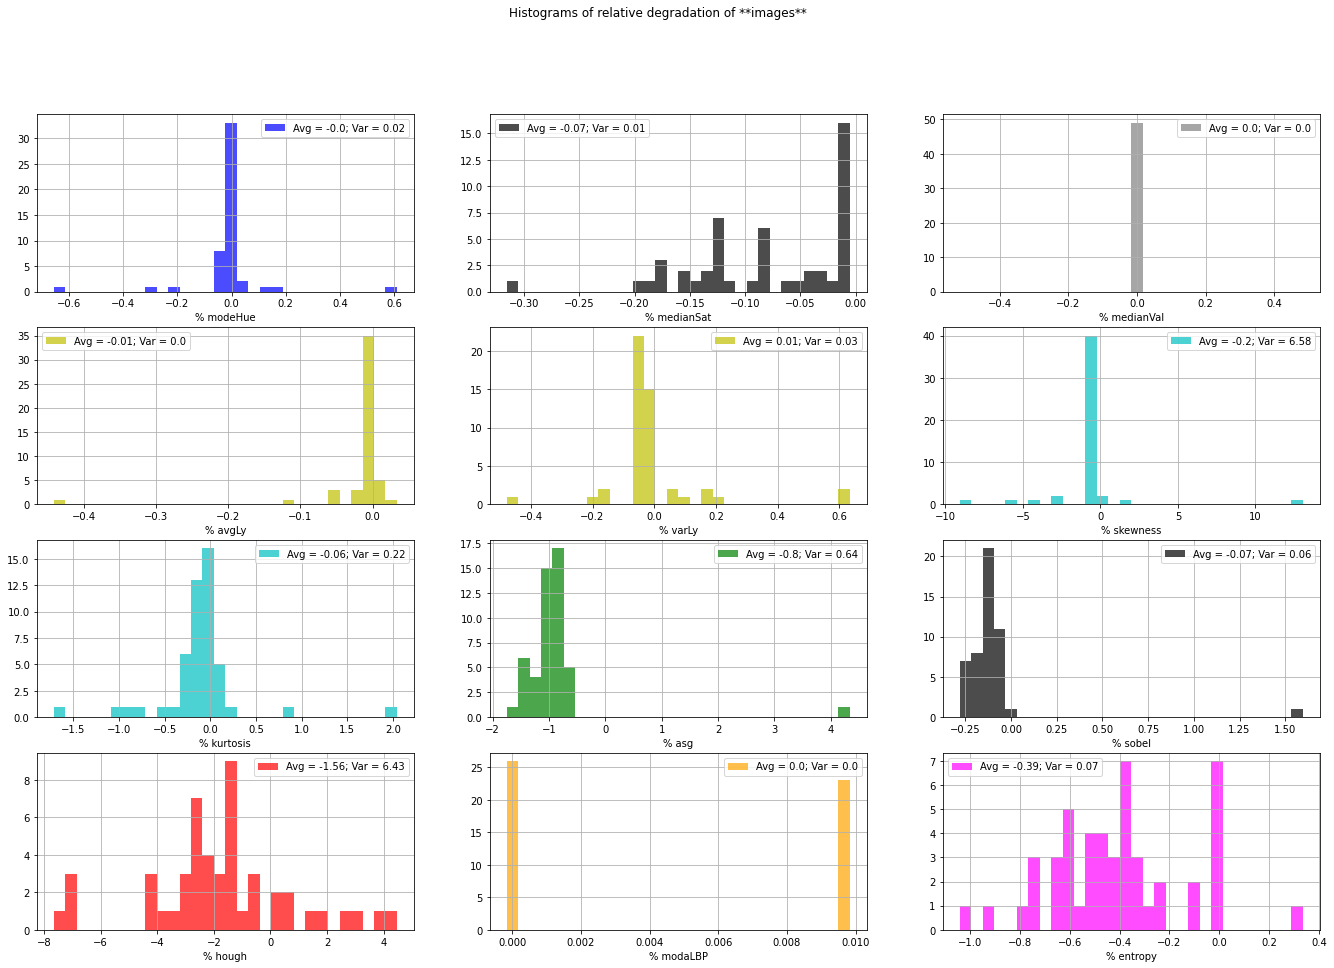

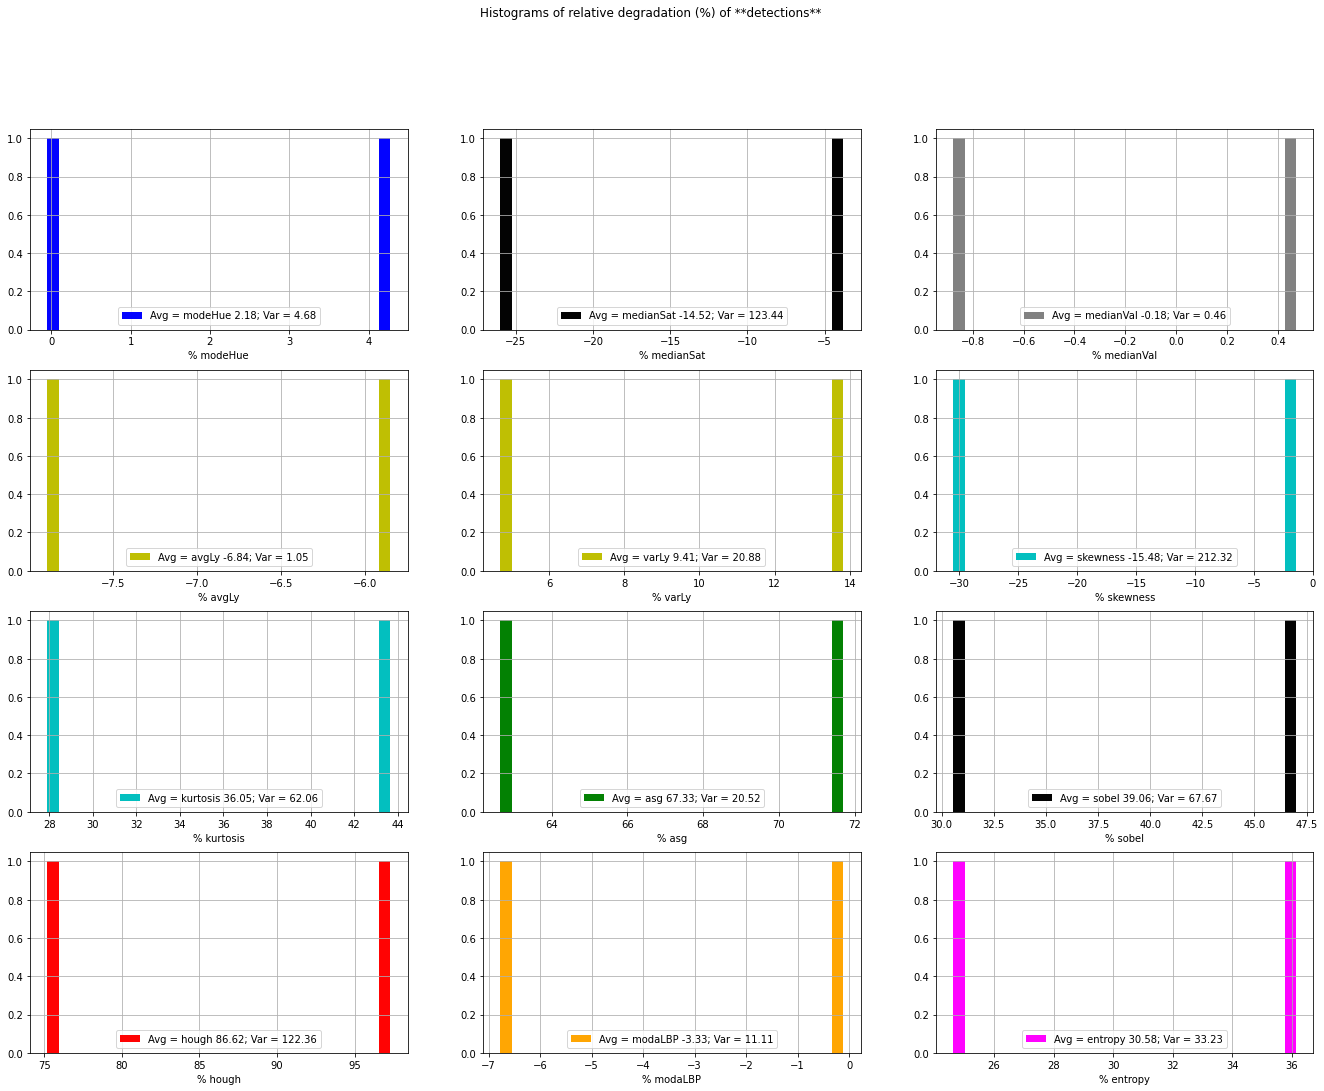

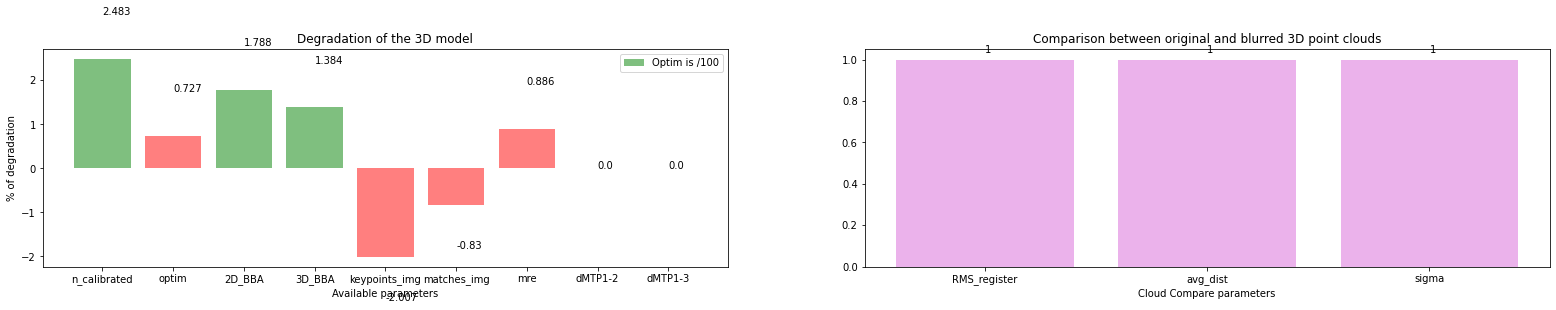

/home/asoria/Documents/proyecto_cars/street_italy
/home/asoria/Documents/proyecto_cars/street_italy/report_original.xml
/home/asoria/Documents/proyecto_cars/street_italy/report_blurred.xml
Initial folder checks
N images  20
Folder exists: True , and there are 20 images of resolution: 1440 px, 1920 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  8
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


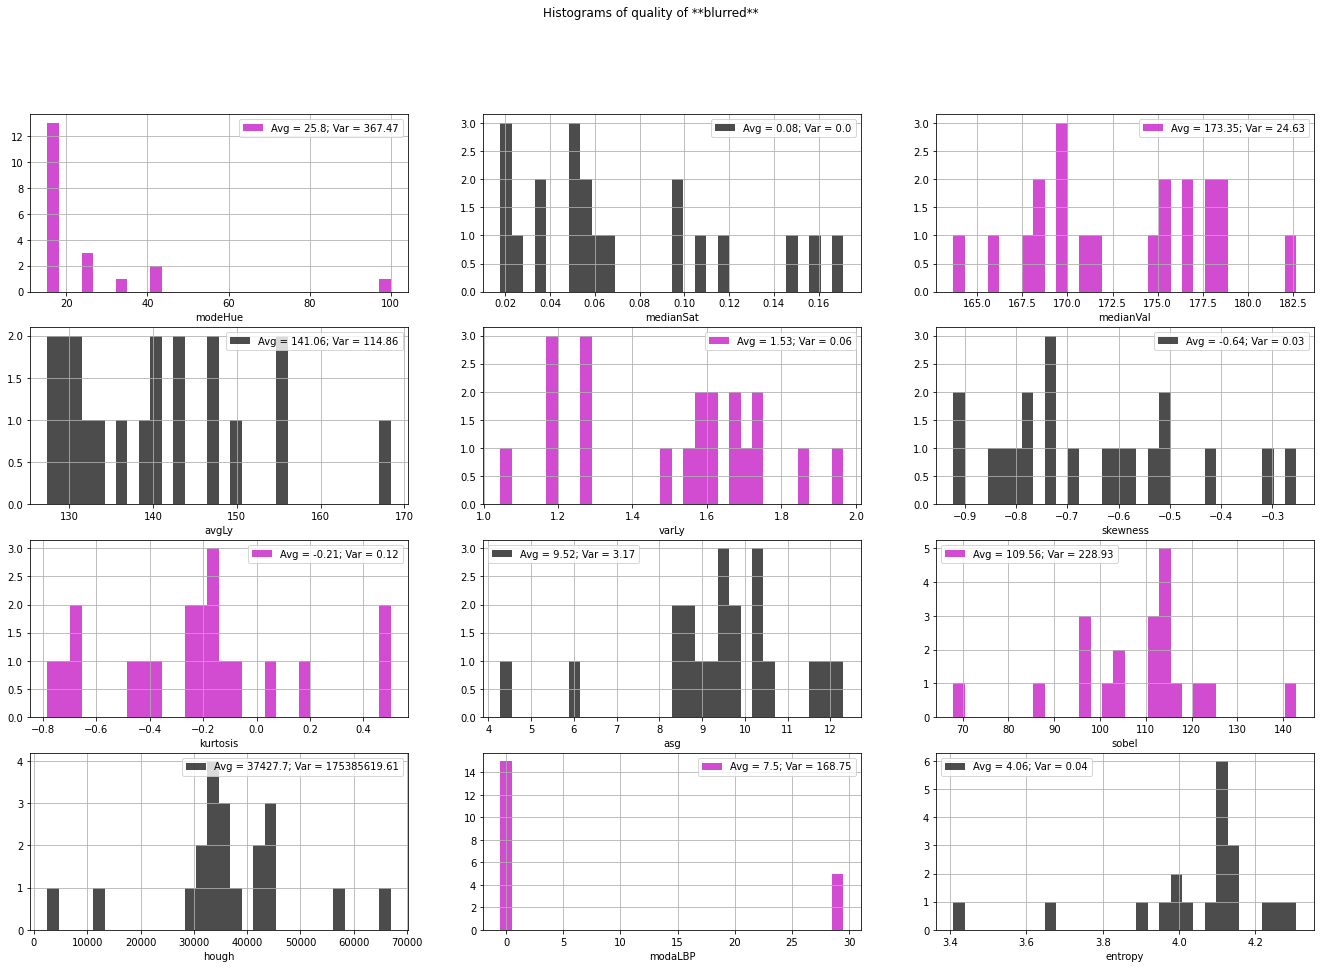

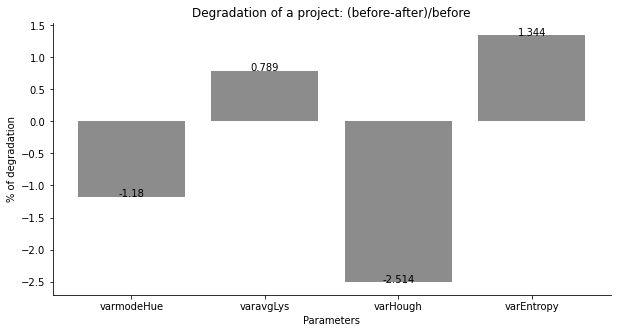

DONE report before path
DONE results after path
                before    after  degradation_perc
n_calibrated       174      174          0.000000
optim             0.22     0.62         -1.818182
2D_BBA         1344014  1327165          1.253633
3D_BBA          408486   405711          0.679338
keypoints_img    11279    11256          0.203919
matches_img       6823     6726          1.421662
mre             0.1875   0.1875          0.000000
dMTP1-2            1.3      1.3          0.000000
dMTP1-3            1.3      1.3          0.000000
<BarContainer object of 9 artists>


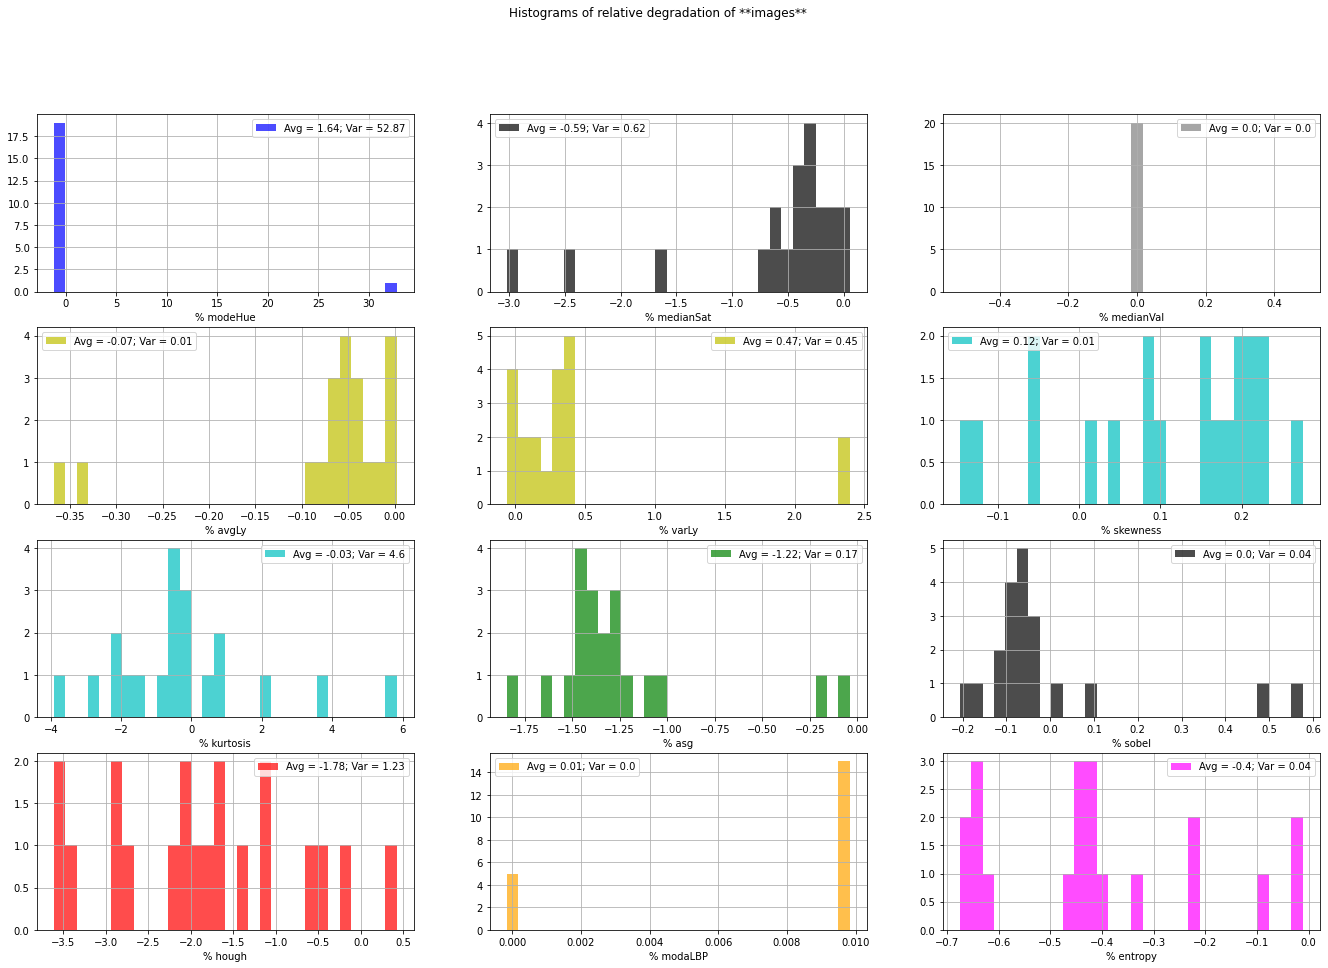

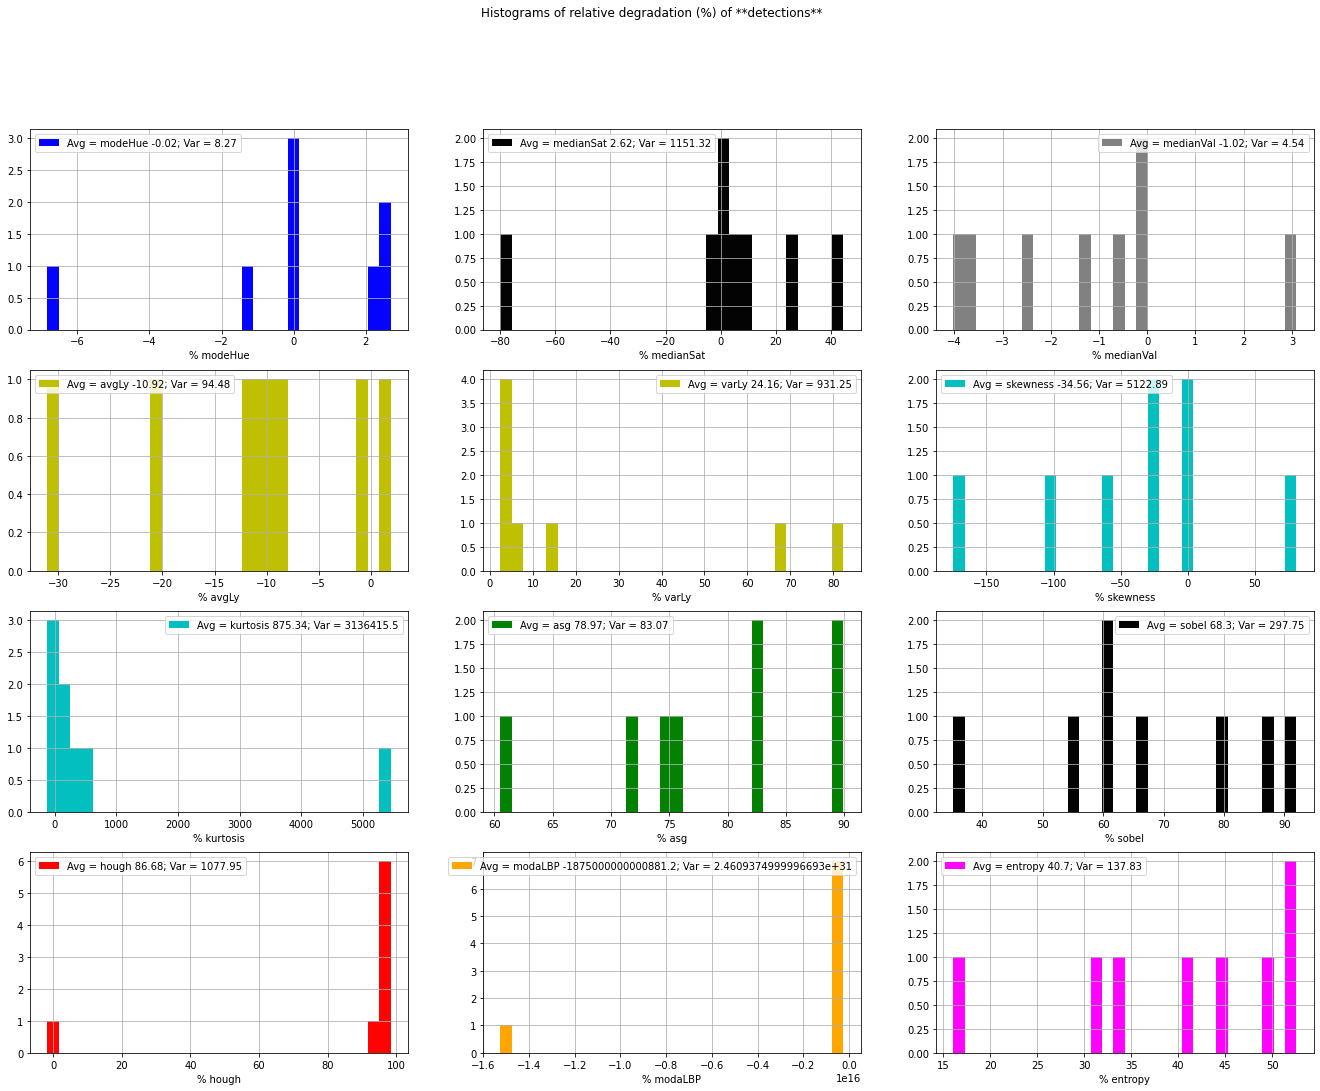

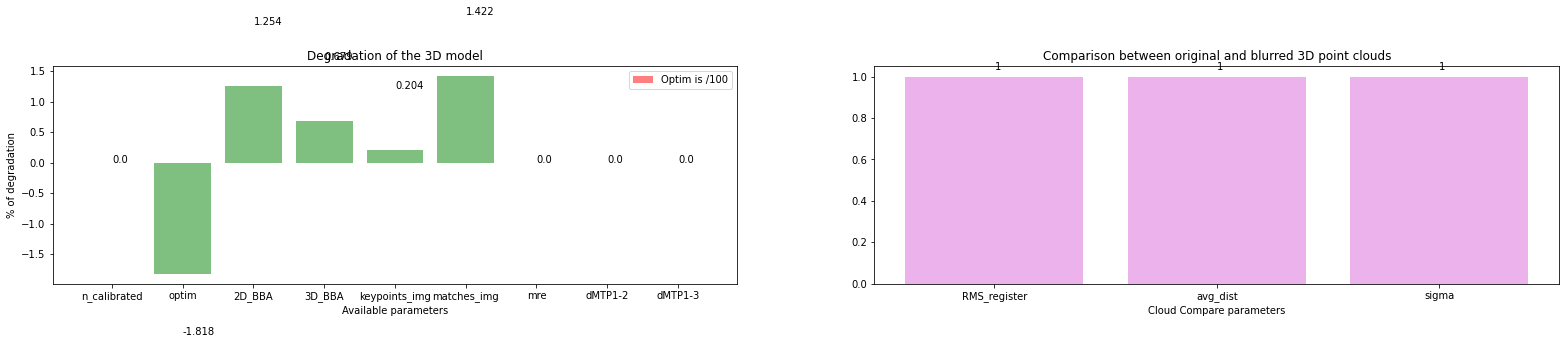

/home/asoria/Documents/proyecto_cars/blue_tractor
/home/asoria/Documents/proyecto_cars/blue_tractor/report_original.xml
/home/asoria/Documents/proyecto_cars/blue_tractor/report_blurred.xml
Initial folder checks
N images  37
Folder exists: True , and there are 37 images of resolution: 1080 px, 1920 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  48
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


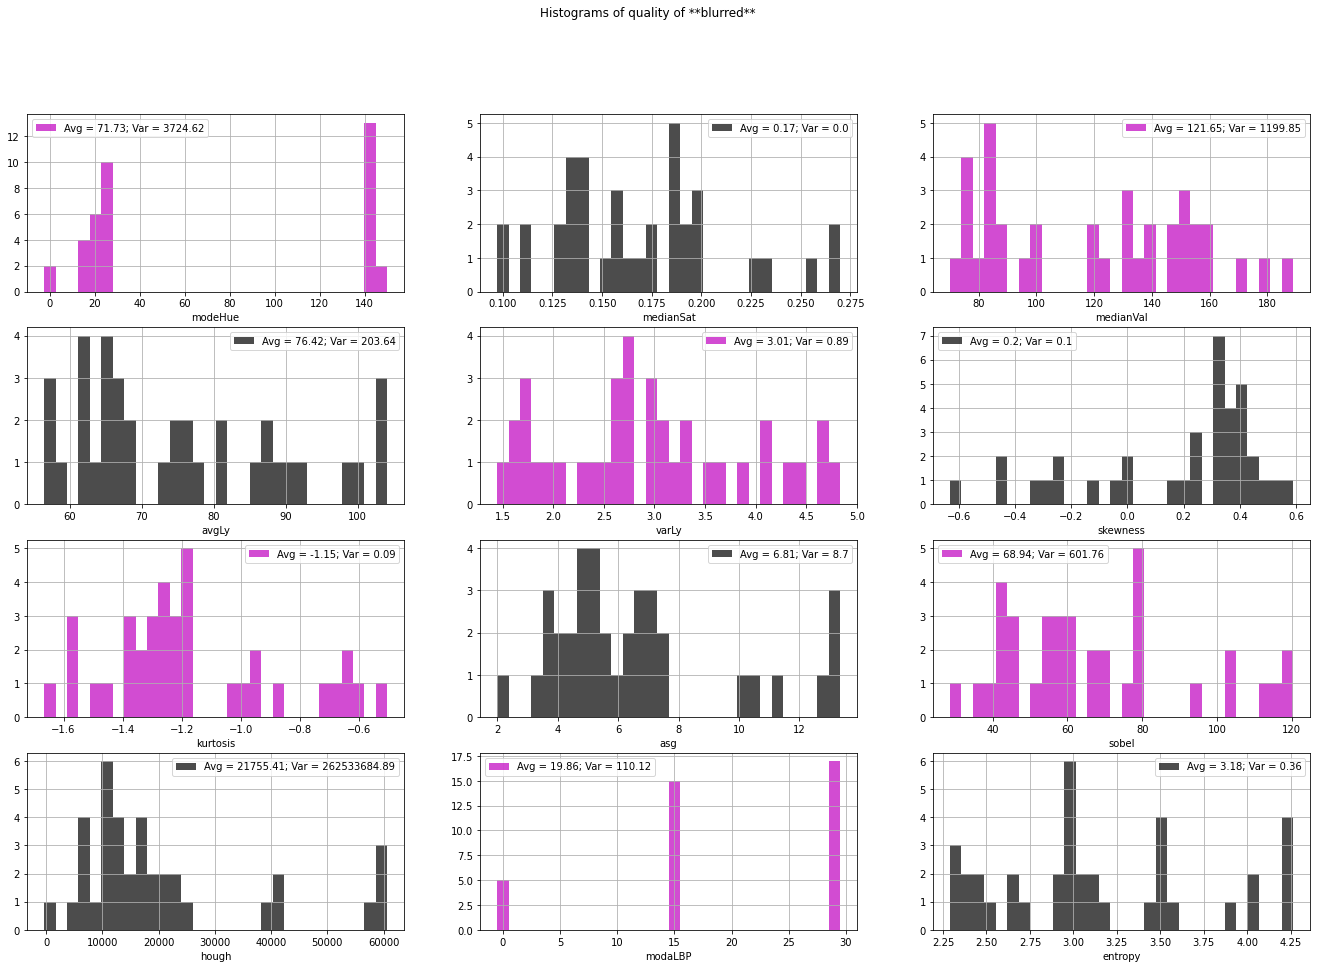

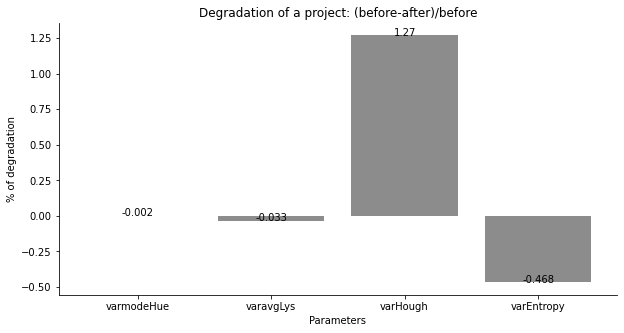

DONE report before path
DONE results after path
               before   after  degradation_perc
n_calibrated      297     297          0.000000
optim            0.05    0.03          0.400000
2D_BBA         986365  934041          5.304730
3D_BBA         329540  320317          2.798750
keypoints_img    8754    8639          1.313685
matches_img      3369    3220          4.422677
mre            0.3352    0.33          1.551313
dMTP1-2           1.3     1.3          0.000000
dMTP1-3           1.3     1.3          0.000000
<BarContainer object of 9 artists>


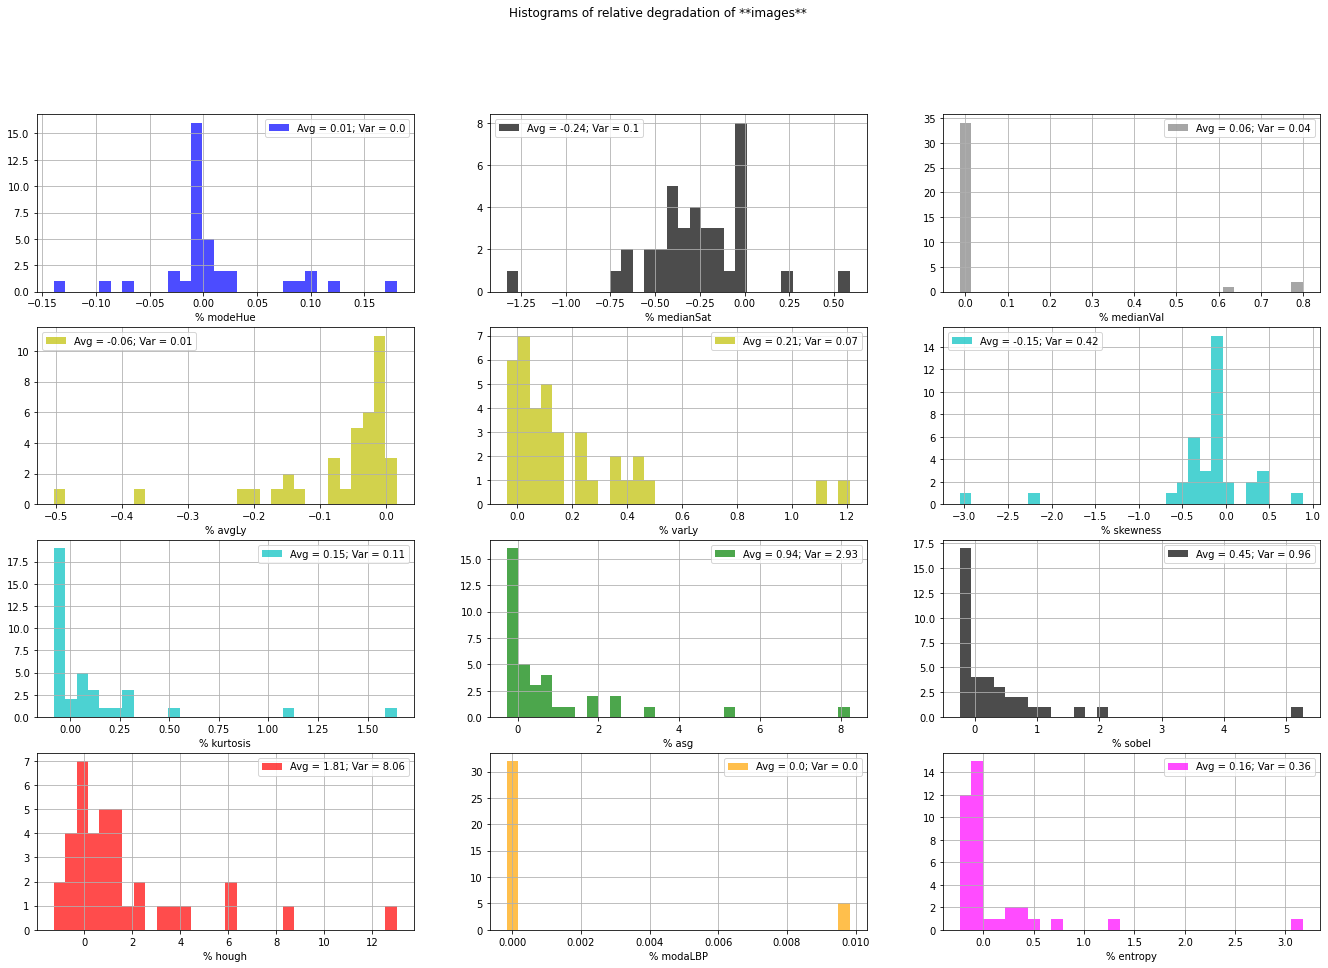

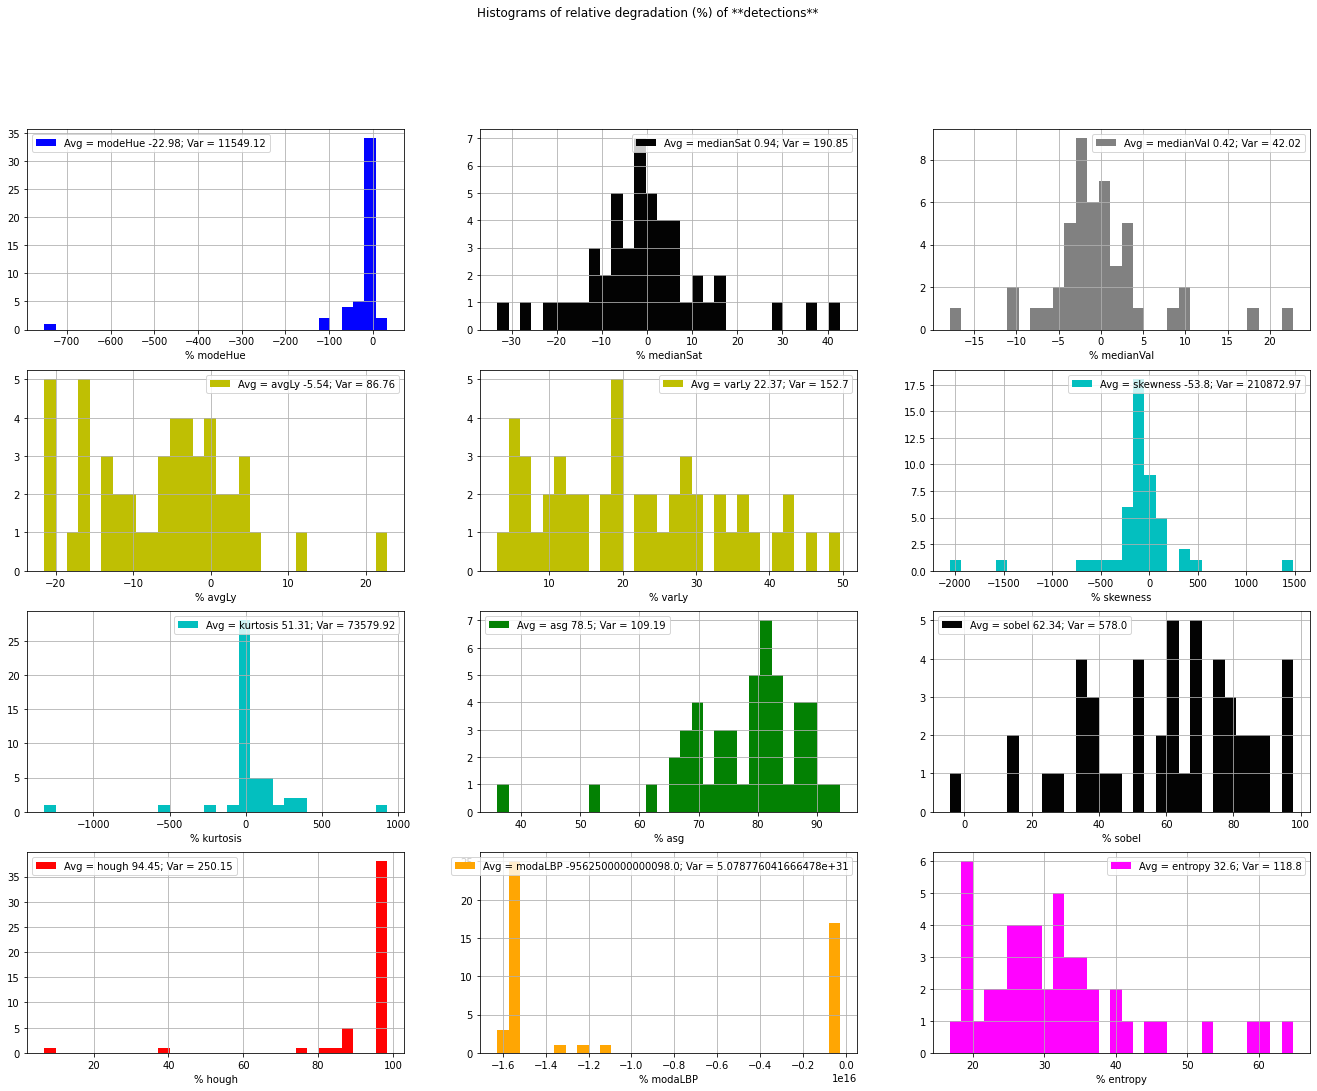

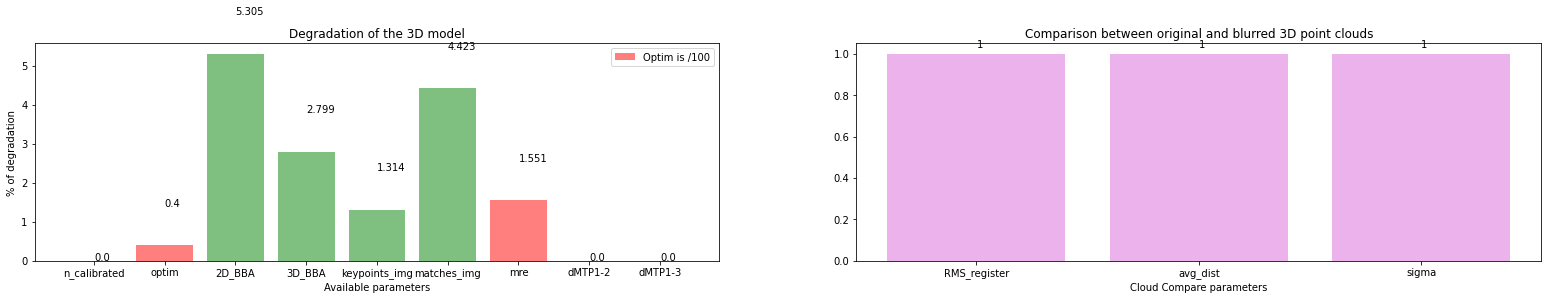

/home/asoria/Documents/proyecto_cars/van_madrid
/home/asoria/Documents/proyecto_cars/van_madrid/report_original.xml
/home/asoria/Documents/proyecto_cars/van_madrid/report_blurred.xml
Initial folder checks
N images  23
Folder exists: True , and there are 23 images of resolution: 1440 px, 1920 px and 3 BGR color spaces.
Project quality checks
Detection algorithm
Calculate ideal parameters
Filter detections
Number of detections considered good =  7
Number of detections considered bad =  0
Blurring algorithm
Evaluate blurred detections


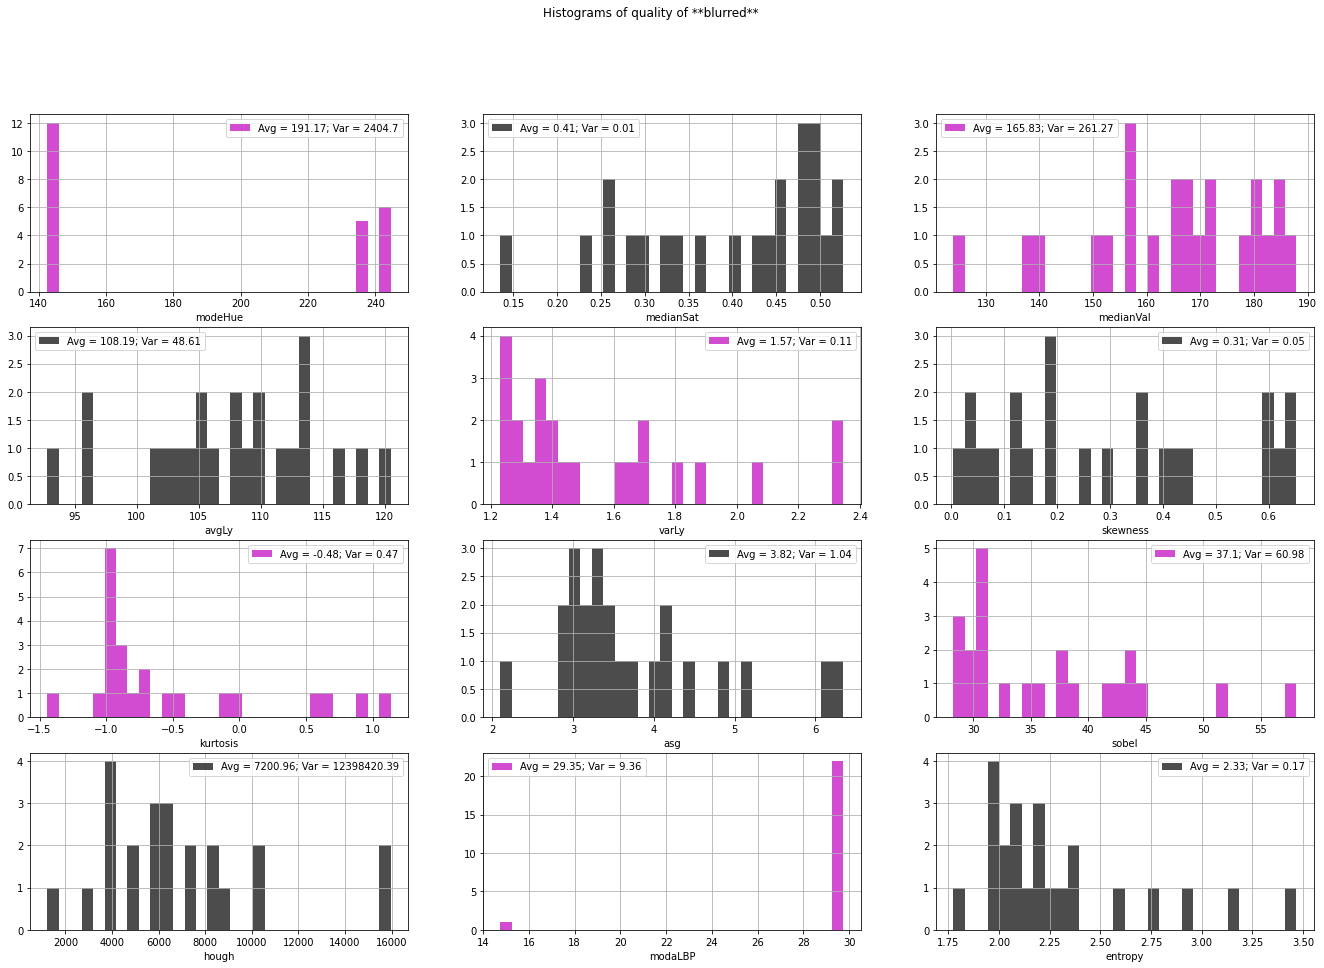

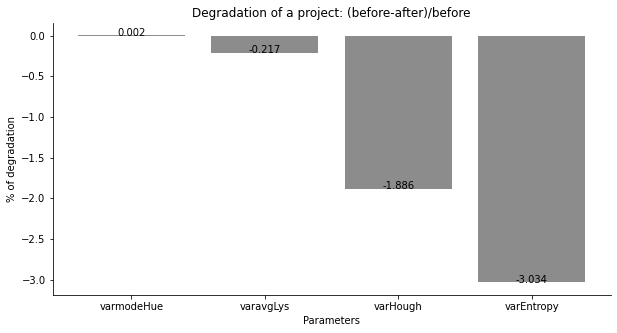

DONE report before path
DONE results after path
               before   after  degradation_perc
n_calibrated      221     221          0.000000
optim            1.21    1.22         -0.008264
2D_BBA         822343  817830          0.548798
3D_BBA         241792  240850          0.389591
keypoints_img    9407    9333          0.786648
matches_img      3700    3674          0.702703
mre            0.3192  0.3185          0.219298
dMTP1-2           1.3     1.3          0.000000
dMTP1-3           1.3     1.3          0.000000
<BarContainer object of 9 artists>


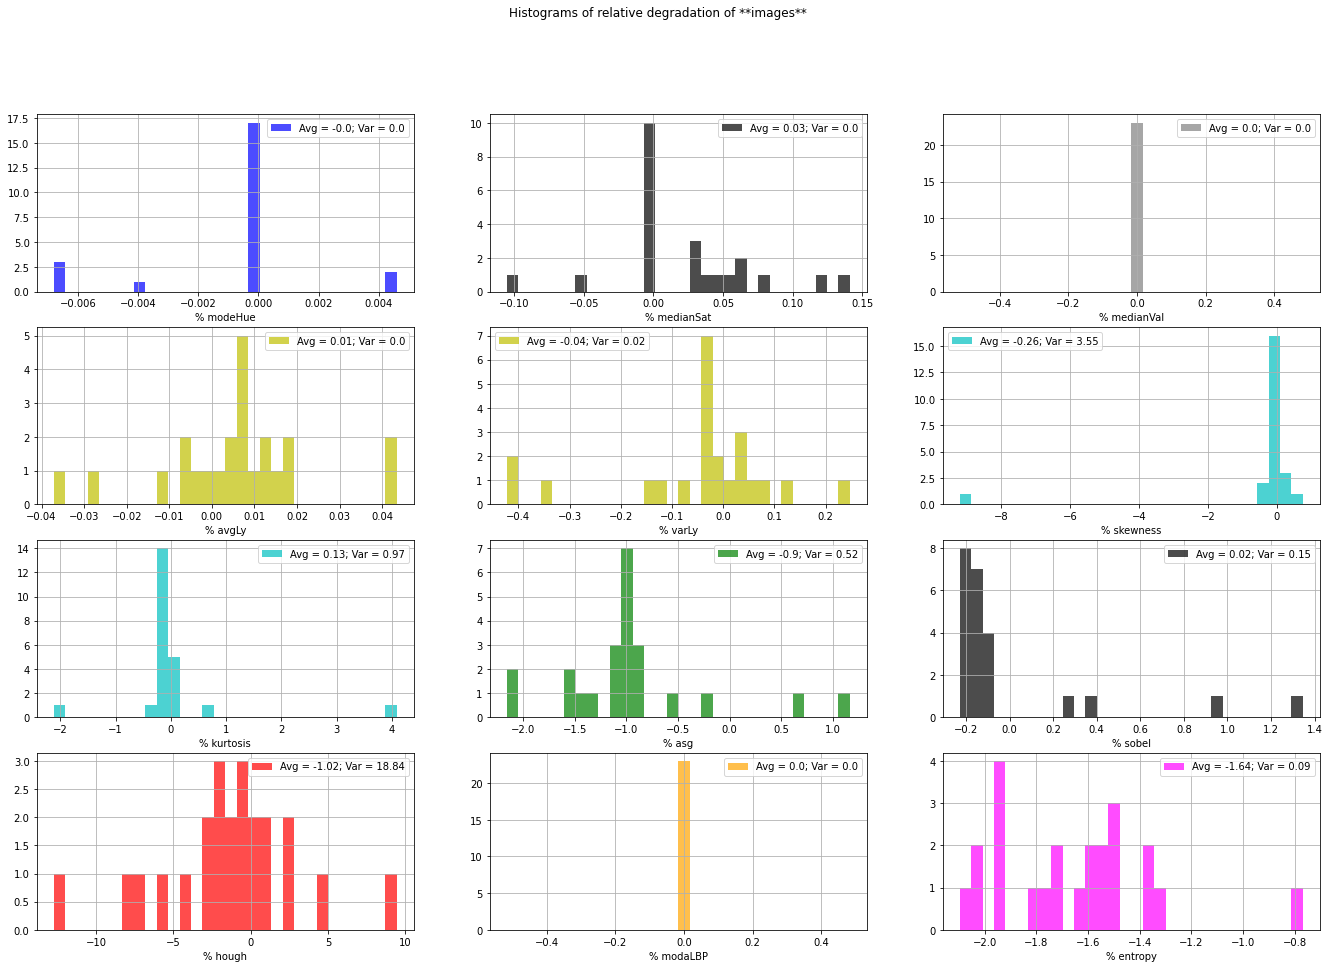

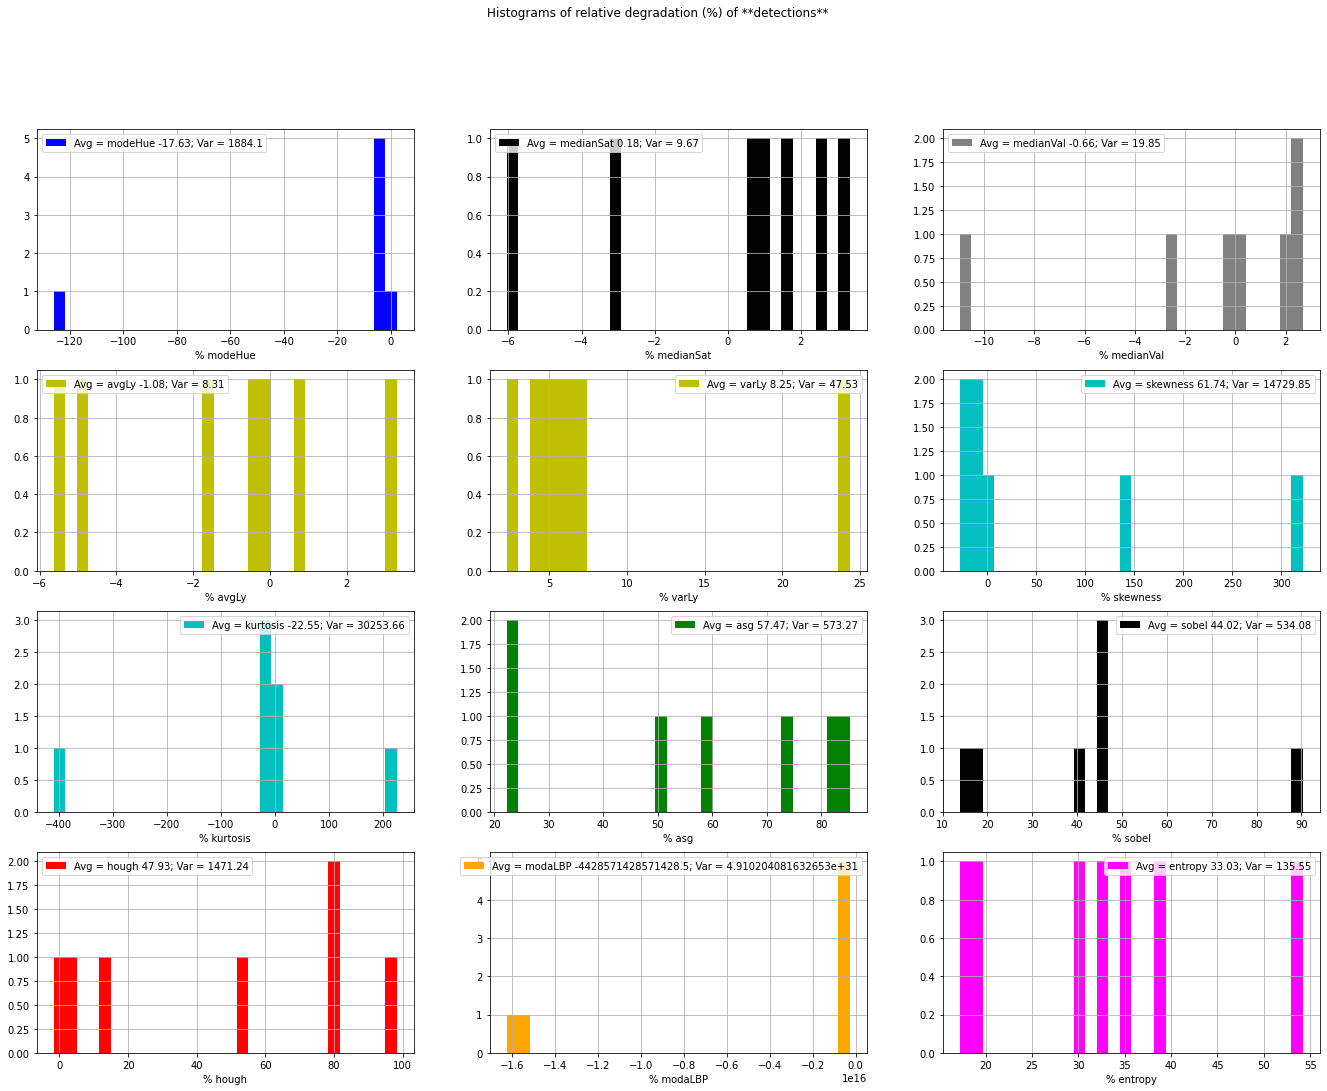

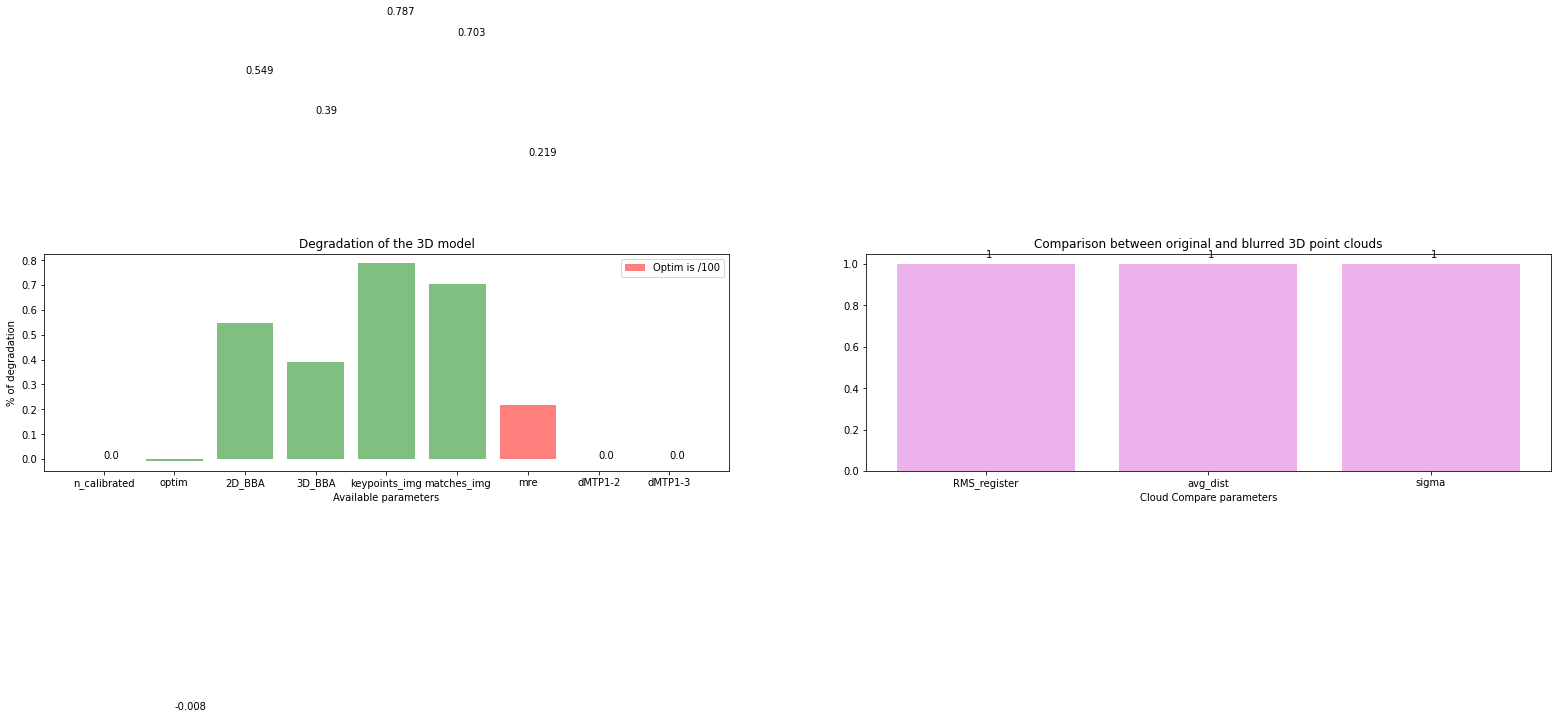

[[2.1806938181895585e-14, 0.4032258064509299, -1.1764705882352933, -5.4140574678914035, 14.135950324139326, 0.9330957731454602, 16.734895147276, 74.36435203418384, 39.77220956719814, 99.99999999999945, -1399.9999999998602, 24.808976570469458], [-0.09970414279051396, -0.2501779048305156, 0.0, 0.016659424279191787, 11.687445727286242, -26.722893273322562, -0.11982075569080901, 77.6317851256066, 47.209070709924745, 99.9999999999999, -1499.9999999998502, 39.15272797984745], [-0.16480690881201704, -0.26864035087702126, 0.0, -3.7708505621125603, 10.765083093101456, -8.367135678121912, 8.052995586003213, 80.29620603601714, 70.25433804523595, 99.99999999999963, -1399.9999999998602, 36.97524364581572], [0.0, -0.921238687782168, 0.0, -0.42128075727405145, 3.2263706536033787, -5.508050283178187, 2.6446667005870204, 42.45934805773143, 29.736630354047968, 39.79489164086681, 0.0, 37.3435847406939], [2.184427553502105, -14.522448157275017, -0.17982567487517978, -6.836568218632312, 9.414099074858353, 

In [3]:
# Extract all data from the projects (LONG)
X = []
y = []

path = "/home/asoria/Documents/proyecto_bretagne/"
for folder in os.listdir(path):
    hs = join(path, folder)
    print(hs)

    folder_path = join(hs,"original_images/")

    report_before_path = join(hs,"report_original.xml")
    report_after_path = join(hs,"report_blurred.xml")
    print(report_before_path)
    print(report_after_path)
    medians_images, medians_detections, deg_results = q_analyze_blur(hs, folder_path, report_before_path, report_after_path, 10);
    X.append(medians_detections)
    y.append(deg_results)


path2 = "/home/asoria/Documents/proyecto_cars/"
for folder2 in os.listdir(path2):
    hs2 = join(path2, folder2)
    print(hs2)

    folder_path2 = join(hs2,"original_images/")

    report_before_path2 = join(hs2,"report_original.xml")
    report_after_path2 = join(hs2,"report_blurred.xml")
    print(report_before_path2)
    print(report_after_path2)
    medians_images2, medians_detections2, deg_results2 = q_analyze_blur(hs2, folder_path2, report_before_path2, report_after_path2, 10);
    X.append(medians_detections2)
    y.append(deg_results2)
print(X,y)

REAL DATA

In [ ]:
"""
#Just to store the variables in case I want to only run the prediction algorithm and sth breaks:

X = [
    [0.0199558311, 0, 0, -3.9370087362, 18.1592909049, -0.808846786, 16.5768207287, 75.5403011247, 39.1180097594, 65, 48, 28.4595938473],
    [-0.0168090344, 0.0089584329, 0, -0.0448896291, 8.4565450346, -30.3476015054, -3.4740930435, 79.5554377008, 43.0944470812, 50, 4, 40.0772691041],
    [0.0163331972, 1.5478931614, 0, -2.1828865439, 10.5976672075, -9.4476631758, 10.031817702, 77.744974176, 40.2467232074, 0, 52, 34.4465434312],
    [0.1623376623, 0.8058774055, 0.4057247899, -0.9957830294, 5.0915314259, 6.9093835695, -0.4786840135, 38.2275653214, 32.8210491585, 0, 48, 36.579091585],
    [0, -3.4120734908, 0.6172839506, 1.042405631, 8.6160769487, -94.1124430578, 43.9298421859, 71.8558320226, 32.6462947771, 0, 52, 24.8169337259],
    [0.0941619586, 0.5823889189, 0, -7.4179417169, 5.1572279748, 18.7093819757, 110.9876290928, 84.7017225768, 47.2196202126, 50, 24,36.8991484894],
    [-0.4792029888, 2.4178165399, 0, -3.6982467117, 14.8585268207, -20.6270145682, 12.5431186905, 80.3602041372, 41.2572774253, 0, 4, 32.1162358838],
    [-1.1332417582, 0.6707946336, 0, -5.7105939381, 9.1955119904, -28.7427256034, -19.7869835932, 80.3615461255, 45.0920910076, 100, 48, 29.494804]
    ]

y = [
    {'n_calibrated': 9.887359199, 'optim': -24.3703703704, '2D_BBA': -192.6595635743, '3D_BBA': -188.5383087964, 'keypoints_img': 0.3947604522, 'matches_img': -251.2678653757, 'mre': -64.7688564477, 'dMTP1-2': -0.4486316734, 'dMTP1-3': -0.524071482},
    {'n_calibrated': -95.6043956044, 'optim': -109.8461538462, '2D_BBA': -337.8341652475, '3D_BBA': -243.4074988887, 'keypoints_img': -15.4049704988, 'matches_img': -255.0597460792, 'mre': -48.1721425266, 'dMTP1-2': 0.1588772673, 'dMTP1-3': 0.011724704},
    {'n_calibrated': -5.6910569106, 'optim': -29.9787234043, '2D_BBA': -164.9237496766, '3D_BBA': -156.5558523693, 'keypoints_img': 3.989168216, 'matches_img': -165.5316021558, 'mre': -60.9733700643, 'dMTP1-2': -75.3124180722, 'dMTP1-3': -0.524071482},
    {'n_calibrated': -7.9812206573, 'optim': -3.4482758621, '2D_BBA': 7.6408096975, '3D_BBA': 5.3123181151, 'keypoints_img': -0.5094882965, 'matches_img': 14.8945518453, 'mre': -5.0495049505, 'dMTP1-2': 2.2277227723, 'dMTP1-3': 0.9493670886},
    {'n_calibrated': 2.4830699774, 'optim': 72.7272727273, '2D_BBA': 1.7884586328, '3D_BBA': 1.3840167832, 'keypoints_img': -2.0069501386, 'matches_img': -0.8304093567, 'mre': 0.8862629247, 'dMTP1-2': -1.2307692308, 'dMTP1-3': -1.3705641492},
    {'n_calibrated': 0, 'optim': -181.8181818182, '2D_BBA': 1.2536327747, '3D_BBA': 0.6793378476, 'keypoints_img': 0.2039187871, 'matches_img': 1.4216620255, 'mre': 0, 'dMTP1-2': 0, 'dMTP1-3': -0.3058954394},
    {'n_calibrated': 0, 'optim': 40, '2D_BBA': 5.3047299935, '3D_BBA': 2.7987497724, 'keypoints_img': 1.3136851725, 'matches_img': 4.4226773523, 'mre': 1.5513126492, 'dMTP1-2': 99.4870903243, 'dMTP1-3': 97.2577043323},
    {'n_calibrated': 0, 'optim': -0.826446281, '2D_BBA': 0.5487977644, '3D_BBA': 0.3895910535, 'keypoints_img': 0.7866482407, 'matches_img': 0.7027027027, 'mre': 0.2192982456, 'dMTP1-2': -595.8904109589, 'dMTP1-3': -54.7557840617}
    ]

#DONt use GSD because there are NaNs
"""

In [4]:
dfY = pd.DataFrame(y)
names = ['mode_hue', 'median_sat', 'median_val', 'avgLy', 'varLy', 'skewness', 'kurt', 'asg', 'sobel', 'hough', 'moda', 'entrop']
X_df = pd.DataFrame(data=np.array(X), columns=names)

In [5]:
# Choose which value you want to predict, so from 'y' full of dictionaries, choose only one parameter
yvals = dfY['mre'].values
yvals

array([-64.76885645, -48.17214253, -60.97337006,  -5.04950495,
         0.88626292,   0.        ,   1.55131265,   0.21929825])

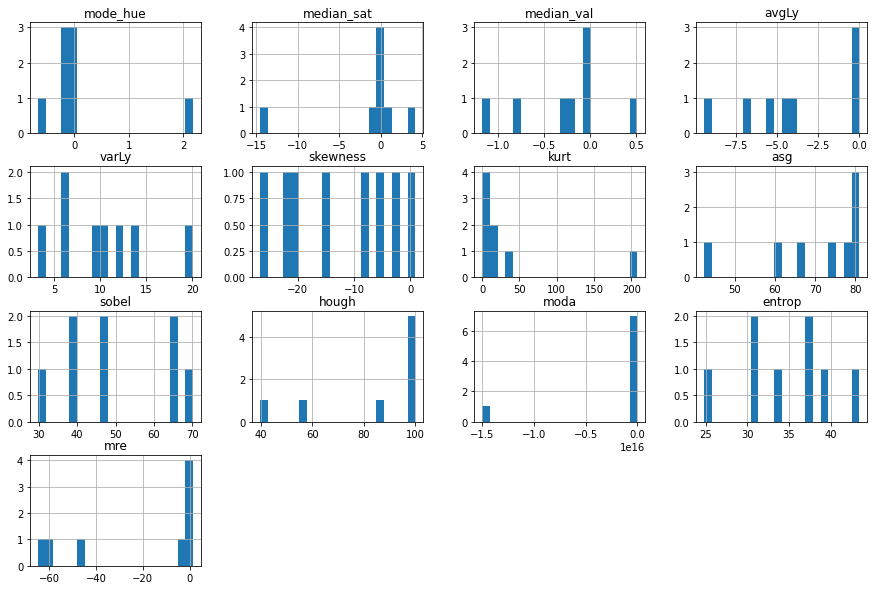

In [6]:
# Analyze the data (missing values, zeros, etc.)


X_df['mre'] = np.array(yvals)
f, ax0 = plt.subplots(figsize=(15,10))
X_df.hist(ax = ax0, bins = 20);

In [7]:
# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, yvals, test_size=0.2, random_state=1)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [83]:

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators=len(est.estimators_)
    test_dev = np.empty(n_estimators)
    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.gca()

    #ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, label='Train %s' % label, linewidth=2, alpha=alpha)

    ax.set_ylabel('Error')
    ax.set_xlabel('number of estimators')
    return test_dev, ax



{'subsample': 0.8}
{}
{'learning_rate': 0.02}
{'min_samples_leaf': 3}


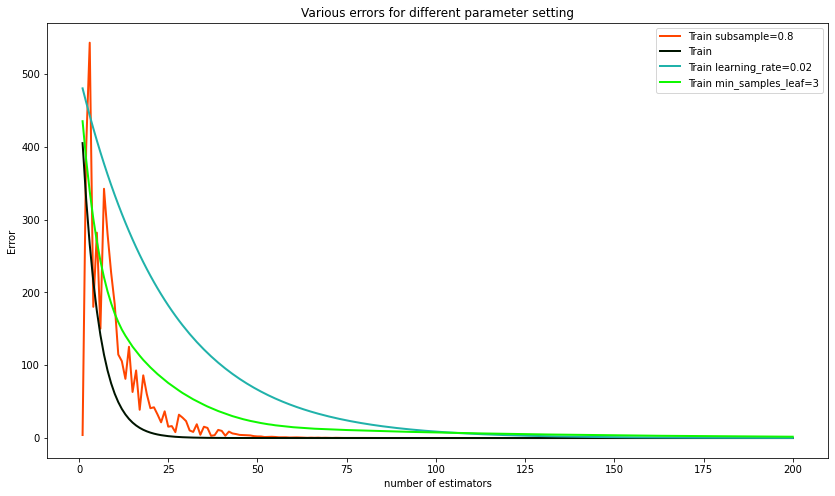

In [85]:
# Some visual first results on parameter dependency 1

fig = plt.figure(figsize=(14, 8))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({'subsample':0.8},('#ffffff', '#ff4500')), ({}, ('#ffffff', '#001400')), ({'learning_rate': 0.02},('#ffffff', '#20b2aa')), ({'min_samples_leaf':3},('#ffffff', '#0ff800')) ]:

   """,  
   ({'min_samples_leaf': 3},('#ff69b4', '#c71585')), 
   ,
   ({'max_depth': 5} ,('#ff6347', '#ff4500')) , 
   ({'max_features': 'sqrt' },('#0000ff', '#70808b')) , 
   ]:
   """


   print(params)
   est = GradientBoostingRegressor(n_estimators=200, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting');


{}
{'min_samples_leaf': 3}
{'learning_rate': 0.02}


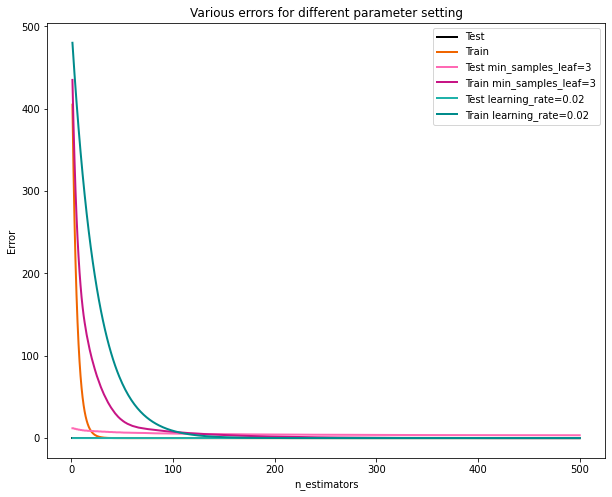

In [9]:
# Some visual first results on parameter dependency 2

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#000000', '#f06500')),  
 ({'min_samples_leaf': 3},('#ff69b4', '#c71585')), 
 ({'learning_rate': 0.02},('#20b2aa', '#008b8b'))
  ]:

   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting');

{}
{'max_depth': 5}
{'max_features': 'sqrt'}


Text(0.5, 1.0, 'Various errors for different parameter setting')

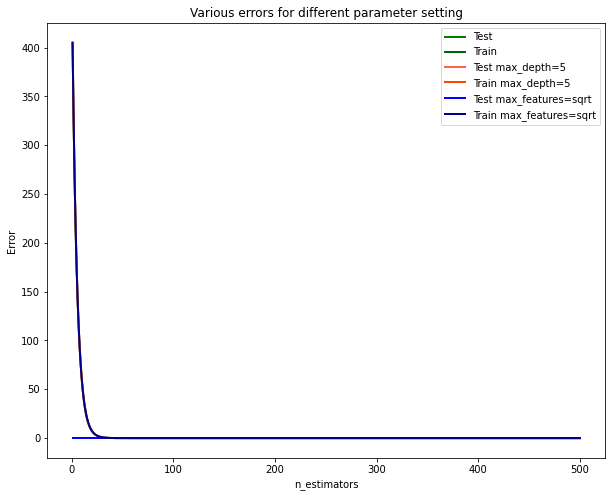

In [10]:
# Some visual first results on parameter dependency 3

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#008000', '#006400')),  
 ({'max_depth': 5} ,('#ff6347', '#ff4500')) , 
 ({'max_features': 'sqrt' },('#0000ff', '#00008b')) ,
  ]:



   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting')

{}
{'subsample': 0.5}


Text(0.5, 1.0, 'Various errors for different parameter setting')

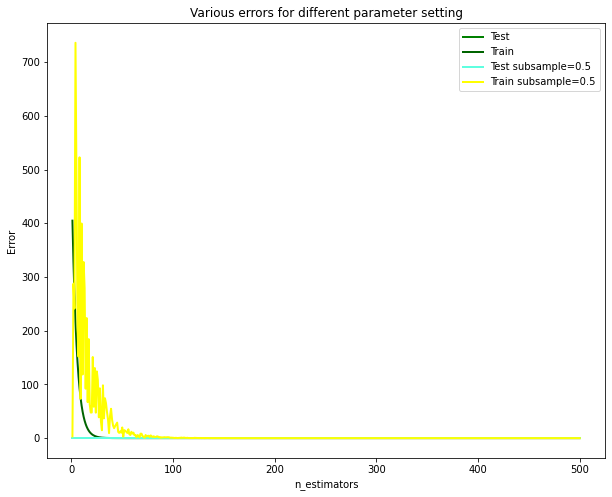

In [11]:
# Some visual first results on parameter dependency 4

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#008000', '#006400')),  
 ({'subsample': 0.5},('#5fffe0', '#ffff00')) ]:



   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting')

In [ ]:
# Tune the hyperparameters
#param_grid = {'learning_rate': [0.5, 0.1, 0.05, 0.02],'max_depth': [1, 3, 5, 9],'min_samples_leaf': [1, 3, 10, 17], 'max_features': ['sqrt','log2'], 'subsample': [0.1, 0.5, 0.8]}

param_grid = {'learning_rate': [0.5, 0.1, 0.05, 0.02], 'max_depth':  [1, 3, 5, 9],'min_samples_leaf': [1, 3, 10, 17], 'max_features': ['sqrt','log2'], 'subsample': [0.1, 0.5, 0.8]}

est = GradientBoostingRegressor(n_estimators=500)

# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=2).fit(X_train,y_train)

# best hyperparameter setting
gs_cv.best_params_





In [ ]:
y_train

In [12]:
# Create the estimator with good parameters

estimator = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.5, max_depth = 1, max_features = 'sqrt', min_samples_leaf = 1, subsample = 0.5)
estimator.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, max_features='sqrt',
                          n_estimators=500, subsample=0.5)

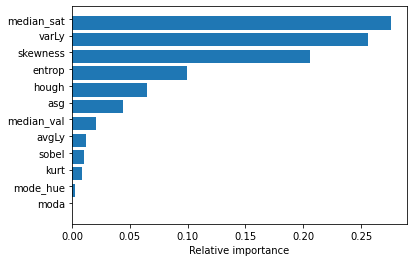

In [13]:
# sort importances
indices = np.argsort(estimator.feature_importances_)

# plot as bar chart
plt.barh(np.arange(len(names)), estimator.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

In [44]:
list(estimator.feature_importances_[indices]*100)

[0.014160515428299268,
 0.24088826649328907,
 0.8727112155642421,
 1.0597262086846775,
 1.2162453545300584,
 2.0465375180019794,
 4.3914453402079365,
 6.5237818885629295,
 9.95274536481136,
 20.55665862387099,
 25.558129076184883,
 27.56697062765936]

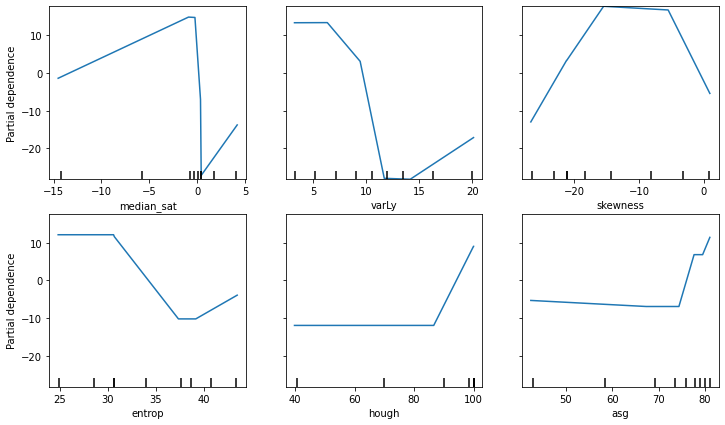

In [15]:
# See the partial dependency of "y" on one feature
#names = ['mode_hue', 'median_sat', 'median_val', 'avgLy', 'varLy', 'skewness', 'kurt', 'asg', 'sobel', 'hough', 'moda', 'entrop']

features = ['median_sat', 'varLy', 'skewness', 'entrop','hough', 'asg']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);


features = ['median_val', 'avgLy', 'sobel', 'kurt','mode_hue', 'median_val']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

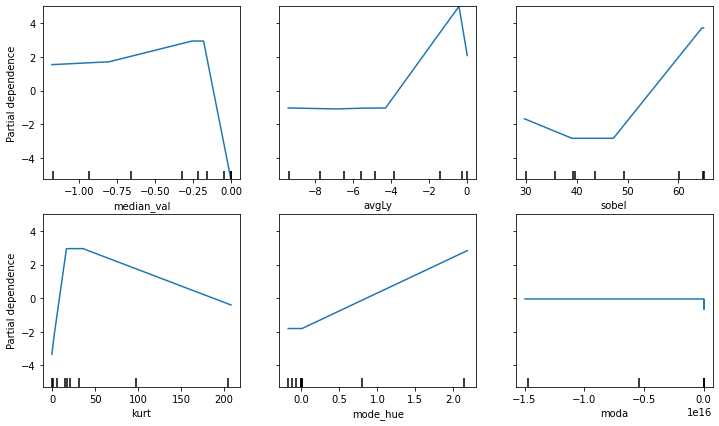

In [16]:
# See the partial dependency of "y" on one feature part 2

features = ['median_val', 'avgLy', 'sobel', 'kurt','mode_hue', 'moda']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

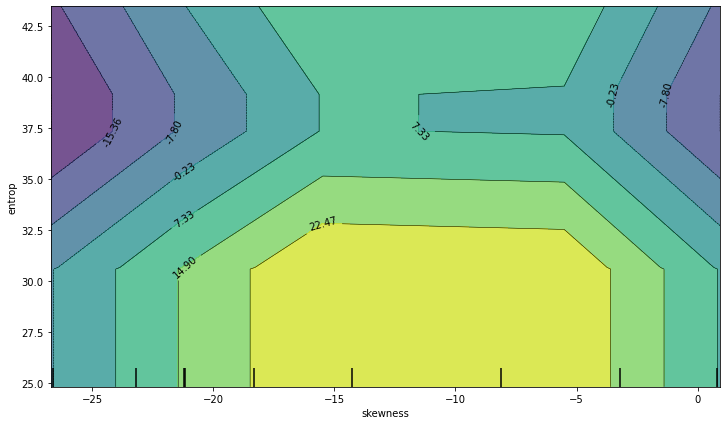

In [32]:
# See the partial dependency of "y" on two features
features2 = [('skewness', 'entrop')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features2, feature_names=names, ax=ax);

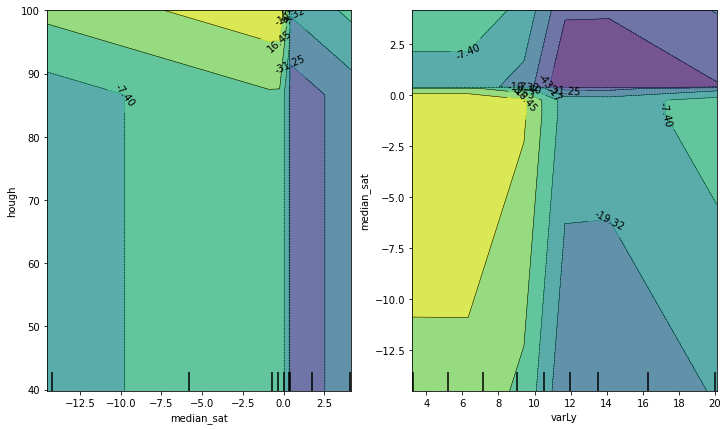

In [28]:
# See the partial dependency of "y" on two features
features2 = [('median_sat', 'hough'), ('varLy', 'median_sat')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features2, feature_names=names, ax=ax);

In [33]:
print("Model Accuracy: %.3f" % estimator.score(X_test, y_test))

Model Accuracy: -1.865


In [34]:
# Calculate the MAE
mae = mean_absolute_error(y_test, estimator.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 51.7717


FAKE DATA

In [ ]:
# Extract the data
cal_housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(cal_housing.data, np.log(cal_housing.target), test_size=0.2, random_state=1)
names = cal_housing.feature_names

In [ ]:
# Check some data
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
f, ax0 = plt.subplots(figsize=(15,8))
X_df.hist(bins=14, ax=ax0);

In [ ]:
# Some visual first results on parameter dependency

fig = plt.figure(figsize=(20, 15))
ax = plt.gca()

# light - dark
# green, pink, blue, orange,, dark blues, yellow
for params, (test_color, train_color) in [({}, ('#008000', '#006400')),  
 ({'min_samples_leaf': 3},('#ff69b4', '#c71585')), 
 ({'learning_rate': 0.02},('#20b2aa', '#008b8b')),
 ({'max_depth': 5} ,('#ff6347', '#ff4500')) , 
 ({'max_features': 'sqrt' },('#0000ff', '#00008b')) , 
 ({'subsample': 0.5},('#ffffe0', '#ffff00')) ]:



   print(params)
   est = GradientBoostingRegressor(n_estimators=500, loss = 'huber')
   est.set_params(**params)
   est.fit(X_train, y_train)

   test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params), train_color=train_color, test_color=test_color)


   ax.legend(loc='upper right')
ax.set_title('Various errors for different parameter setting')



In [ ]:
# Tune the hyperparameters
param_grid = {'learning_rate': [0.5, 0.1, 0.05, 0.02],'max_depth': [1, 3, 5, 9],'min_samples_leaf': [1, 3, 10, 17], 'max_features': ['sqrt','log2'], 'subsample': [0.1, 0.5, 0.8]}


est = GradientBoostingRegressor(n_estimators=800)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=2).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

In [ ]:
# Create the estimator with good parameters

estimator = GradientBoostingRegressor(n_estimators = 800, learning_rate = 0.02, max_depth = 9, max_features = 'log2', min_samples_leaf = 3, subsample = 0.8)
estimator.fit(X_train, y_train)

In [ ]:
# sort importances
indices = np.argsort(estimator.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), estimator.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

In [ ]:
# See the partial dependency of "y" on one feature
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
f, ax1 = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features,feature_names=names, ax = ax1);

In [ ]:
# See the partial dependency of "y" on two features
features2 = [('MedInc', 'AveOccup'), ('HouseAge', 'AveRooms'),('AveOccup', 'HouseAge')]
f, ax = plt.subplots(figsize=(12,7))
plot_partial_dependence(estimator, X_train, features2, feature_names=names, ax=ax);

In [ ]:
print("Model Accuracy: %.3f" % estimator.score(X_test, y_test))

In [ ]:
# Calculate the MAE
mae = mean_absolute_error(y_test, estimator.predict(X_test))
print('MAE: %.4f' % mae)